$$
\begin{aligned}
\begin{array}{c@{\hskip 4mm}l@{\hskip 4mm}l@{\hskip 4mm}S[table-format = 5.0]@{\hskip 4mm}S[table-format = 4.0]@{\hskip 2mm}S[table-format = 2.1]@{\hskip 2mm}S[table-format = 2.1]} \hline
\text{Dataset}          & \text{Class}       & \text{Classification Criteria} & \text{traces} & \text{uniq.} & \text{uniq.\%} & \text{top-10\%}  \\ 
\hline
\text{BPIC17}   & L{+} & \text{without activity `A_incomplete'}                     & 16506               & 529    & 3.2    & 83.5    \\
                          & L{-} & \text{with activity `A_incomplete'}                        & 15003               & 2101   & 14.0   & 51.5    \\
\hline
\text{Traffic}  & L{+} & \text{end activity `Payment'}                               & 67201               & 122    & 0.2    & 99.1    \\
                          & L{-} & \text{end activity not `Payment'}                           & 83169               & 109    & 0.1    & 99.2    \\
\hline
\text{COVID}    & L{+} & \text{with activity `Discharge alive'}                      & 136                  & 33    & 24.0   & 74.3    \\
                          & L{-} & \text{with activity `Discharge dead'}                       & 60                   & 20    & 33.0   & 83.3    \\
\hline
\text{BPIC18}   & L{+} & \text{duration less than 9 months}                          & 27966               & 1081   & 3.9    & 57.7    \\
                          & L{-} & \text{duration more than 9 months}                          & 15843               & 477    & 3.0    & 82.1    \\
\hline
\text{Hospital} & L{+} & \text{duration less than 3 months}                          & 41343               & 306    & 0.7    & 95.3   \\
                          & L{-} & \text{duration more than 3 months}                          & 58653               & 884    & 1.5    & 89.7   \\
\hline
\end{array}
\end{aligned}
$$

## Imports & Constants

In [10]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from src.preprocessing import load_split_data_as_df, construct_train_data
from src.visualization.feature_importance import model_coef, tree_mdi, tree_permutation, tree_mdi_permutation
from src.visualization.eda import analyse_data, plot_unique_events_per_trace_location, plot_cumulative_dist_of_traces, plot_hist_by_attr
from src.utils import print_info, print_warning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# Change directory to repo
os.chdir("../")

DATA_DIR = "./data/"
SPLIT_BY = 'unique'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <font color='green'> <b> Make Dataset </b> </font>

Download datasets in a `.zip` file containing 2 `.xes` files (L+ & L- event logs) for each dataset.\
For downloading `COVID` dataset please get in contact with the authors of the following paper: [arXiv](https://arxiv.org/abs/2202.04625)

In [127]:
!wget https://uni-bielefeld.sciebo.de/s/tCZqLtFl4rg7F5R/download -O 'data.zip'
# Unzip datasets
!unzip 'data.zip'

Archive:  data.zip
   creating: data/
   creating: data/BPIC17/
 extracting: data/BPIC17/Lm_final.xes  
 extracting: data/BPIC17/Lp_final.xes  
 extracting: data/BPIC17/read_me.txt  
   creating: data/BPIC18/
 extracting: data/BPIC18/Lm_final.xes  
 extracting: data/BPIC18/Lp_final.xes  
 extracting: data/BPIC18/read_me.txt  
   creating: data/Hospital/
 extracting: data/Hospital/Lm_final.xes  
 extracting: data/Hospital/Lp_final.xes  
 extracting: data/Hospital/read_me.txt  
   creating: data/Traffic/
 extracting: data/Traffic/Lm_final.xes  
 extracting: data/Traffic/Lp_final.xes  
 extracting: data/Traffic/read_me.txt  


In [2]:
# Show possible arguments for the script
%run -m src.data.make_dataset -h

usage: make_dataset.py [-h] --split_by SPLIT_BY [--test_size TEST_SIZE]
                       [--n_threshold N_THRESHOLD]

optional arguments:
  -h, --help            show this help message and exit
  --split_by SPLIT_BY   Possible split options; 'unique', 'time', and 'random'.
  --test_size TEST_SIZE
                        The percentage of the test dataset.
  --n_threshold N_THRESHOLD
                        Keep traces only that occur more than `n_threshold` times.


There are 3 different ways to split datasets into train & test: 
- `unique`: duplicate traces are removed, then the split is performed, 
- `time`: traces are sorted temporally and the most recent portion of data is used for testing,
- `random`: traces are sampled randomly, leaving duplicate traces inside. **Caution!** Train & test sets most probably have some traces identical, i.e. data leakage. 

```python
# Sample traces randomly from 'unique' traces
%run -m src.data.make_dataset -- --split_by unique --test_size 0.3
```

```python
# Sample traces randomly from 'unique' traces (filter out infrequent traces)
%run -m src.data.make_dataset -- --split_by unique_v2 --test_size 0.3 --n_threshold 1
```

```python
# Take last `test_size` percent of data as test set after sorting temporally
%run -m src.data.make_dataset -- --split_by time --test_size 0.3
```

```python
# Sample traces randomly from all traces (with duplicated traces)
%run -m src.data.make_dataset -- --split_by random --test_size 0.3
```

We will split datasets using `unique` method as the paper presents results based on that.

In [ ]:
# Sample traces randomly from 'unique' traces
%run -m src.data.make_dataset -- --split_by unique --test_size 0.3

# <font color='green'> <b> Analysis of dataset</b> </font>

## <font color='green'> <b> BPIC17 </b> </font>

In [16]:
DATASET = 'BPIC17'

# Load data and convert to pandas DataFrame
df_lm_train, df_lm_test, df_lp_train, df_lp_test = load_split_data_as_df(data_dir=DATA_DIR, dataset=DATASET, split_by=SPLIT_BY)

# Group by event names to get traces
lm_traces_train = df_lm_train[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lp_traces_train = df_lp_train[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lm_traces_test = df_lm_test[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lp_traces_test = df_lp_test[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']

[INFO]Loading 'BPIC17' dataset from './data/train_test_splits_unique'...


parsing log, completed traces ::   0%|          | 0/10477 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/631 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/14941 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/159 [00:00<?, ?it/s]

In [3]:
display(df_lm_train.head(2))
print_info(f"L- Train, shape: {df_lm_train.shape}")

display(df_lp_train.head(2))
print_info(f"L+ Train, shape: {df_lp_train.shape}")

display(df_lm_test.head(2))
print_info(f"L- Test, shape: {df_lm_test.shape}")

display(df_lp_test.head(2))
print_info(f"L+ Test, shape: {df_lp_test.shape}")

,Action,EventID,EventOrigin,org:resource,time:timestamp,lifecycle:transition,concept:name,OfferedAmount,CreditScore,Selected,MonthlyCost,Accepted,NumberOfTerms,FirstWithdrawalAmount,OfferID,case:LoanGoal,case:concept:name,case:RequestedAmount,case:ApplicationType
0,Created,Application_652823628,Application,User_1,2016-01-01 10:51:15.304000+01:00,complete,A_Create Application,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Existing loan takeover,Application_652823628,20000.0,New credit
1,statechange,ApplState_1582051990,Application,User_1,2016-01-01 10:51:15.352000+01:00,complete,A_Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Existing loan takeover,Application_652823628,20000.0,New credit


L- Train, shape: (169155, 19)


,Action,EventID,EventOrigin,org:resource,time:timestamp,lifecycle:transition,concept:name,OfferedAmount,CreditScore,Selected,MonthlyCost,Accepted,NumberOfTerms,FirstWithdrawalAmount,OfferID,case:LoanGoal,case:concept:name,case:RequestedAmount,case:ApplicationType
0,Created,Application_1691306052,Application,User_1,2016-01-01 11:16:11.500000+01:00,complete,A_Create Application,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home improvement,Application_1691306052,10000.0,New credit
1,statechange,ApplState_284636842,Application,User_1,2016-01-01 11:16:11.549000+01:00,complete,A_Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home improvement,Application_1691306052,10000.0,New credit


L+ Train, shape: (169151, 19)


,Action,EventID,EventOrigin,org:resource,time:timestamp,lifecycle:transition,concept:name,OfferedAmount,CreditScore,Selected,MonthlyCost,Accepted,NumberOfTerms,FirstWithdrawalAmount,OfferID,case:LoanGoal,case:concept:name,case:RequestedAmount,case:ApplicationType
0,Created,Application_1825972191,Application,User_1,2016-01-02 12:06:39.120000+01:00,complete,A_Create Application,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Car,Application_1825972191,15000.0,New credit
1,statechange,ApplState_539772237,Application,User_1,2016-01-02 12:06:39.156000+01:00,complete,A_Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Car,Application_1825972191,15000.0,New credit


L- Test, shape: (14153, 19)


,Action,EventID,EventOrigin,org:resource,time:timestamp,lifecycle:transition,concept:name,OfferedAmount,CreditScore,Selected,MonthlyCost,Accepted,NumberOfTerms,FirstWithdrawalAmount,OfferID,case:LoanGoal,case:concept:name,case:RequestedAmount,case:ApplicationType
0,Created,Application_196483749,Application,User_17,2016-01-02 10:12:07.481000+01:00,complete,A_Create Application,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Car,Application_196483749,10000.0,New credit
1,statechange,ApplState_369764295,Application,User_17,2016-01-02 10:12:07.505000+01:00,complete,A_Concept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Car,Application_196483749,10000.0,New credit


L+ Test, shape: (2958, 19)


          L-     L+
count  10477  14941
mean      16     11
std        3      2
min       10      7
50%       15     11
75%       18     12
99%       30     21
max       51     45


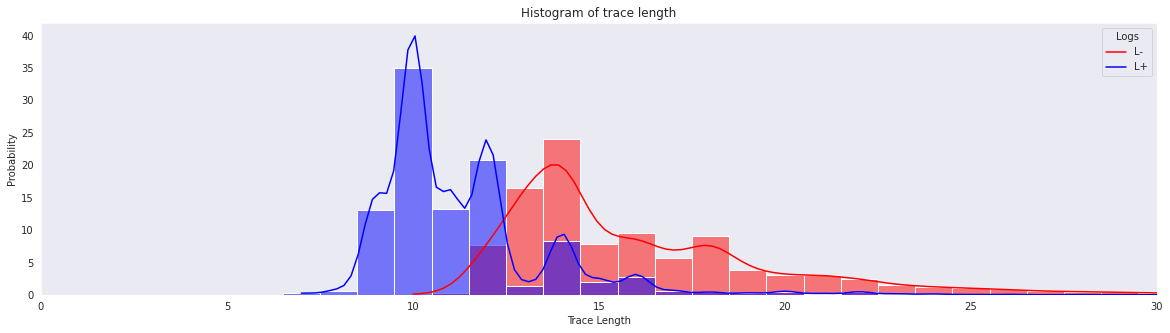

Unique event names in: 
Lminus(18 events): 
['A_Create Application' 'A_Submitted' 'A_Concept' 'A_Accepted'
 'O_Create Offer' 'O_Created' 'O_Sent (mail and online)' 'A_Complete'
 'A_Validating' 'O_Returned' 'A_Incomplete' 'O_Accepted' 'A_Pending'
 'O_Cancelled' 'A_Cancelled' 'A_Denied' 'O_Refused' 'O_Sent (online only)'] 

Lplus(17 events): 
['A_Create Application' 'A_Submitted' 'A_Concept' 'A_Accepted'
 'O_Create Offer' 'O_Created' 'O_Sent (mail and online)' 'A_Complete'
 'A_Validating' 'A_Denied' 'O_Refused' 'A_Cancelled' 'O_Cancelled'
 'O_Returned' 'O_Accepted' 'A_Pending' 'O_Sent (online only)'] 

Their difference in terms of events: 
{'A_Incomplete'}


In [4]:
analyse_data(df_lm_train, df_lp_train, xlim=[0, 30])

        L-   L+
count  631  159
mean    22   18
std      5    5
min     11    7
50%     22   18
75%     25   22
99%     37   38
max     50   40


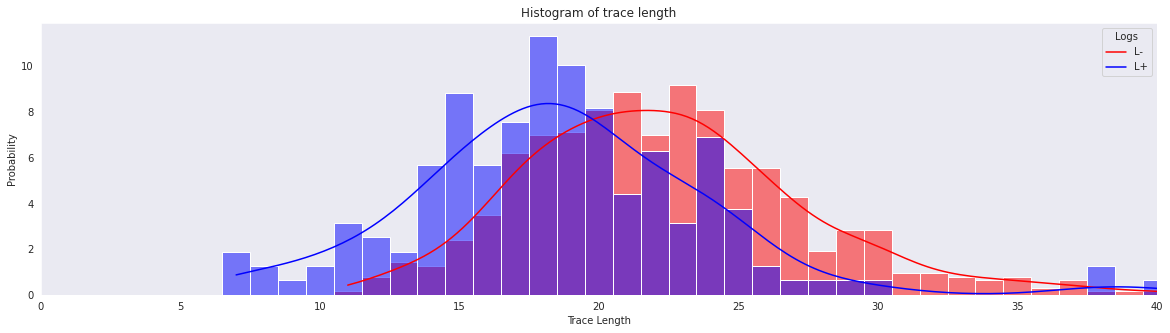

Unique event names in: 
Lminus(18 events): 
['A_Create Application' 'A_Submitted' 'A_Concept' 'A_Accepted'
 'O_Create Offer' 'O_Created' 'O_Sent (mail and online)' 'A_Complete'
 'O_Sent (online only)' 'A_Validating' 'O_Returned' 'A_Incomplete'
 'O_Accepted' 'A_Pending' 'O_Cancelled' 'A_Cancelled' 'A_Denied'
 'O_Refused'] 

Lplus(17 events): 
['A_Create Application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'O_Created' 'O_Sent (online only)' 'A_Complete' 'O_Cancelled'
 'O_Sent (mail and online)' 'A_Cancelled' 'A_Validating' 'O_Returned'
 'O_Accepted' 'A_Pending' 'A_Submitted' 'A_Denied' 'O_Refused'] 

Their difference in terms of events: 
{'A_Incomplete'}


In [5]:
analyse_data(df_lm_test, df_lp_test, xlim=[0, 40])

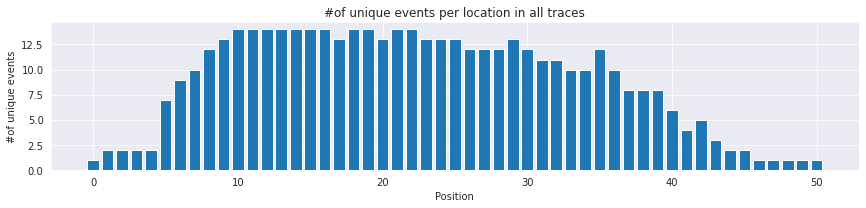

In [6]:
plot_unique_events_per_trace_location(lm_traces_train, lm_traces_test, 
                                      lp_traces_train, lp_traces_test)

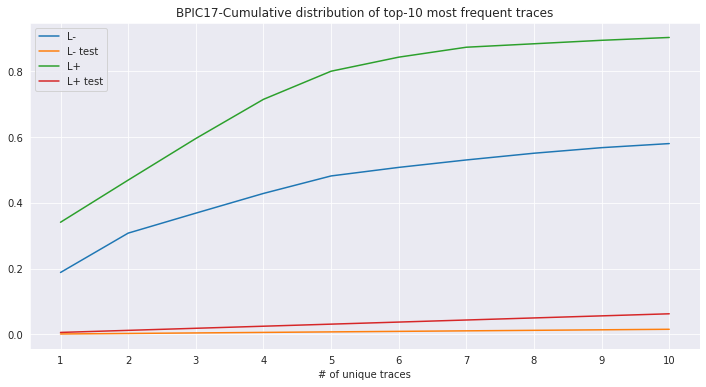

In [7]:
plot_cumulative_dist_of_traces(lm_traces_train, lm_traces_test, 
                               lp_traces_train, lp_traces_test,
                               dataset=DATASET, top_k=10)

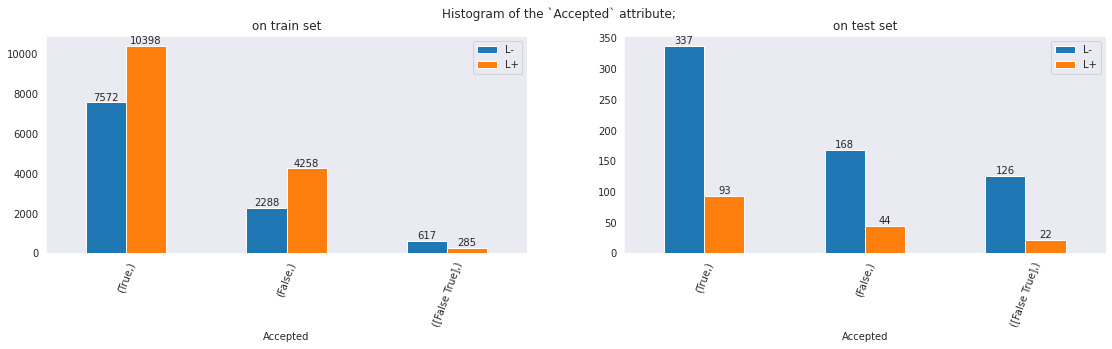

In [8]:
plot_hist_by_attr(df_lm_train, df_lm_test,
                  df_lp_train, df_lp_test, "Accepted")

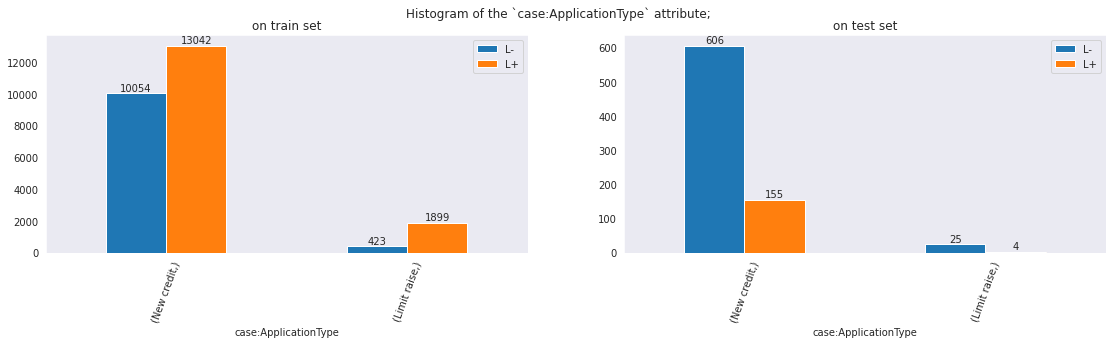

In [9]:
plot_hist_by_attr(df_lm_train, df_lm_test,
                  df_lp_train, df_lp_test, "case:ApplicationType")

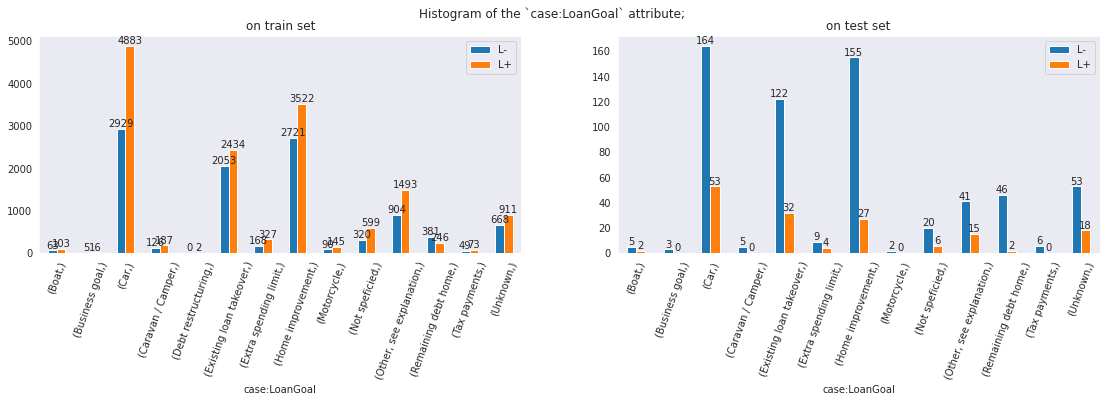

In [10]:
plot_hist_by_attr(df_lm_train, df_lm_test,
                  df_lp_train, df_lp_test, "case:LoanGoal")

In [11]:
# Might need to add the following features:
#     "OfferedAmount", "CreditScore", "Selected", "MonthlyCost", "Accepted", "NumberOfTerms", "case:RequestedAmount"
df_lm_train["Accepted"].unique()

array([nan, True, False], dtype=object)

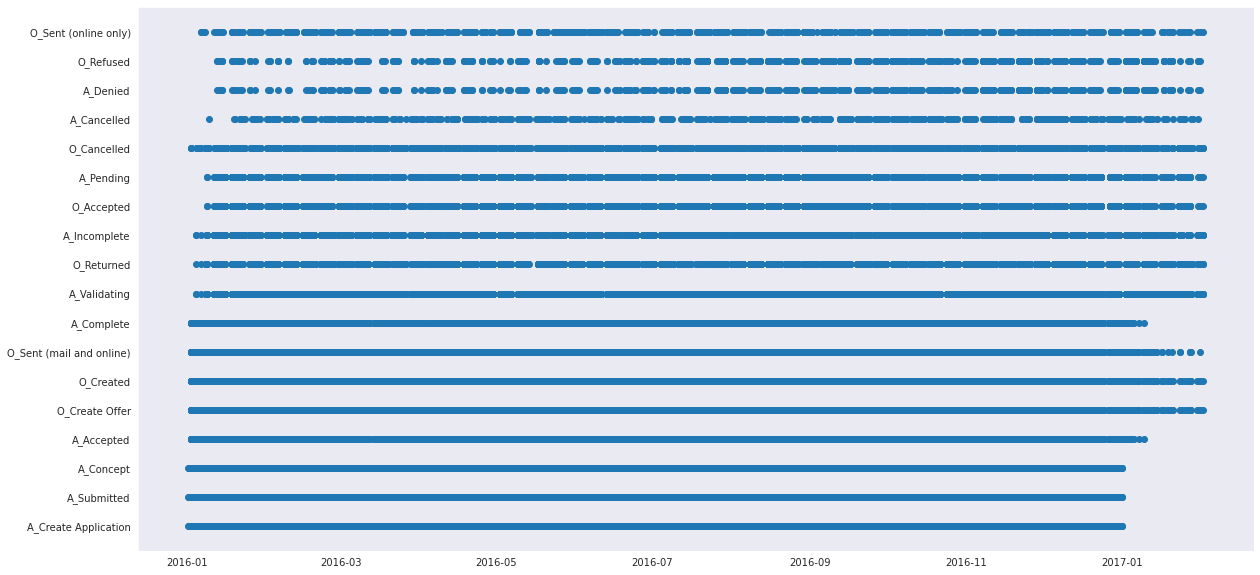

In [12]:
plt.figure(figsize=((20, 10)))
plt.scatter(df_lm_train['time:timestamp'], df_lm_train['concept:name'])

## <font color='green'> <b> BPIC18 </b> </font>

In [18]:
DATASET = 'BPIC18'

# Load data and convert to pandas DataFrame
df_lm_train, df_lm_test, df_lp_train, df_lp_test = load_split_data_as_df(data_dir=DATA_DIR, dataset=DATASET, split_by=SPLIT_BY)

# Group by event names to get traces
lm_traces_train = df_lm_train[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lp_traces_train = df_lp_train[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lm_traces_test = df_lm_test[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lp_traces_test = df_lp_test[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']

[INFO]Loading 'BPIC18' dataset from '../data/train_test_splits_unique'...


parsing log, completed traces ::   0%|          | 0/14224 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/144 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/18606 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/325 [00:00<?, ?it/s]

In [19]:
display(df_lm_train.head(2))
print_info(f"L- Train, shape: {df_lm_train.shape}")

display(df_lp_train.head(2))
print_info(f"L+ Train, shape: {df_lp_train.shape}")

display(df_lm_test.head(2))
print_info(f"L- Test, shape: {df_lm_test.shape}")

display(df_lp_test.head(2))
print_info(f"L+ Test, shape: {df_lp_test.shape}")

,success,org:resource,docid_uuid,doctype,subprocess,docid,activity,note,eventid,identity:id,...,case:amount_applied0,case:penalty_amount1,case:payment_actual1,case:amount_applied1,case:penalty_amount2,case:payment_actual2,case:amount_applied2,case:payment_actual3,case:penalty_amount3,case:amount_applied3
0,True,0;n/a,CD3DC291-76C6-420A-B3F1-7C808970915B,Payment application,Application,-18008611495569447,mail income,none,null,510B5333-731A-40FD-B7D6-FC149E50E961,...,960.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,0;n/a,CD3DC291-76C6-420A-B3F1-7C808970915B,Payment application,Application,-18008611495569447,mail valid,none,null,F1DD45EF-80BF-46A5-97D6-CC5886DD2D23,...,960.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


L- Train, shape: (234481, 75)


,success,org:resource,docid_uuid,doctype,subprocess,docid,activity,note,eventid,identity:id,...,case:amount_applied0,case:penalty_amount1,case:payment_actual1,case:amount_applied1,case:penalty_amount2,case:payment_actual2,case:amount_applied2,case:payment_actual3,case:penalty_amount3,case:amount_applied3
0,True,0;n/a,FCB4D9FC-7646-4217-A334-F3324D624A90,Payment application,Application,-18008611495747535,mail income,none,null,8E64B63F-BB6E-4731-B810-8E07B9D49331,...,1019.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,0;n/a,FCB4D9FC-7646-4217-A334-F3324D624A90,Payment application,Application,-18008611495747535,mail valid,none,null,55E3FC7F-FE48-47F2-BCDE-071884B0F744,...,1019.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


L+ Train, shape: (467680, 75)


,success,org:resource,docid_uuid,doctype,subprocess,docid,activity,note,eventid,identity:id,...,case:amount_applied0,case:penalty_amount1,case:payment_actual1,case:amount_applied1,case:penalty_amount2,case:payment_actual2,case:amount_applied2,case:payment_actual3,case:penalty_amount3,case:amount_applied3
0,True,0;n/a,FE610D15-074B-43FB-9130-1D8C5D675945,Payment application,Application,-18008611496053124,mail income,none,null,9F38C6D7-B4EB-43E6-826C-4F8D719D990C,...,81820.94,195.54,-139.06,81776.93,NaN,NaN,NaN,NaN,NaN,NaN
1,True,0;n/a,FE610D15-074B-43FB-9130-1D8C5D675945,Payment application,Application,-18008611496053124,mail valid,none,null,889EC88B-7D80-4A98-B084-6F46BBF9486C,...,81820.94,195.54,-139.06,81776.93,NaN,NaN,NaN,NaN,NaN,NaN


L- Test, shape: (3290, 75)


,success,org:resource,docid_uuid,doctype,subprocess,docid,activity,note,eventid,identity:id,...,case:amount_applied0,case:penalty_amount1,case:payment_actual1,case:amount_applied1,case:penalty_amount2,case:payment_actual2,case:amount_applied2,case:payment_actual3,case:penalty_amount3,case:amount_applied3
0,True,0;n/a,513A58D7-1C0A-420B-B521-AEE9B80D81D3,Payment application,Application,-18008611496164307,mail income,none,null,9014FAE8-0DCF-4555-A14F-5BF01E9C1CE9,...,2002.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,0;n/a,513A58D7-1C0A-420B-B521-AEE9B80D81D3,Payment application,Application,-18008611496164307,mail valid,none,null,C2192AF5-C7F6-446E-BC75-C96E8F3BD297,...,2002.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


L+ Test, shape: (8465, 75)


          L-     L+
count  14224  18606
mean      16     25
std        3      6
min       10      5
50%       16     27
75%       19     31
99%       29     35
max       42     55


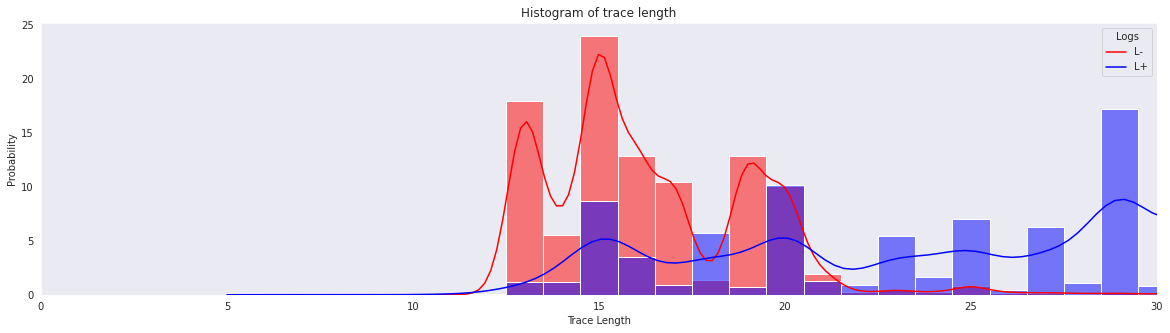

Unique event names in: 
Lminus(13 events): 
['mail income' 'mail valid' 'initialize' 'begin editing' 'calculate'
 'finish editing' 'decide' 'begin payment' 'abort payment'
 'finish payment' 'revoke decision' 'insert document' 'remove document'] 

Lplus(15 events): 
['mail income' 'mail valid' 'initialize' 'begin editing' 'calculate'
 'finish editing' 'decide' 'begin payment' 'abort payment'
 'finish payment' 'revoke decision' 'insert document' 'withdraw'
 'remove document' 'revoke withdrawal'] 

Their difference in terms of events: 
{'revoke withdrawal', 'withdraw'}


In [20]:
analyse_data(df_lm_train, df_lp_train, xlim=[0, 30])

        L-   L+
count  144  325
mean    22   26
std      6    5
min     12   11
50%     22   26
75%     25   30
99%     36   39
max     83   42


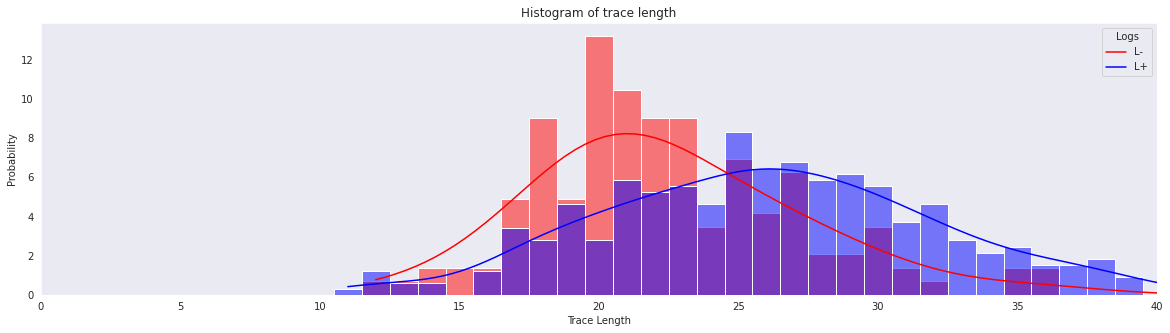

Unique event names in: 
Lminus(15 events): 
['mail income' 'mail valid' 'initialize' 'begin editing' 'calculate'
 'finish editing' 'decide' 'insert document' 'begin payment'
 'finish payment' 'abort payment' 'revoke decision' 'remove document'
 'withdraw' 'revoke withdrawal'] 

Lplus(15 events): 
['mail income' 'mail valid' 'initialize' 'begin editing' 'calculate'
 'finish editing' 'decide' 'begin payment' 'abort payment'
 'finish payment' 'revoke decision' 'insert document' 'withdraw'
 'revoke withdrawal' 'remove document'] 

Their difference in terms of events: 
set()


In [21]:
analyse_data(df_lm_test, df_lp_test, xlim=[0, 40])

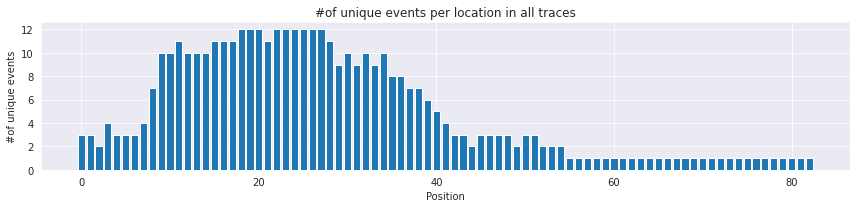

In [22]:
plot_unique_events_per_trace_location(lm_traces_train, lm_traces_test, 
                                      lp_traces_train, lp_traces_test)

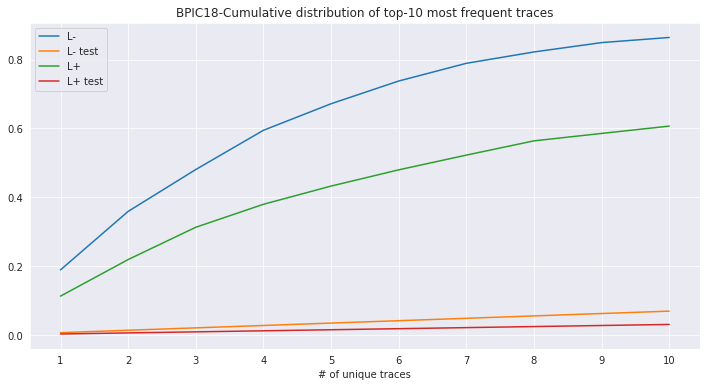

In [23]:
plot_cumulative_dist_of_traces(lm_traces_train, lm_traces_test, 
                               lp_traces_train, lp_traces_test,
                               dataset=DATASET, top_k=10)

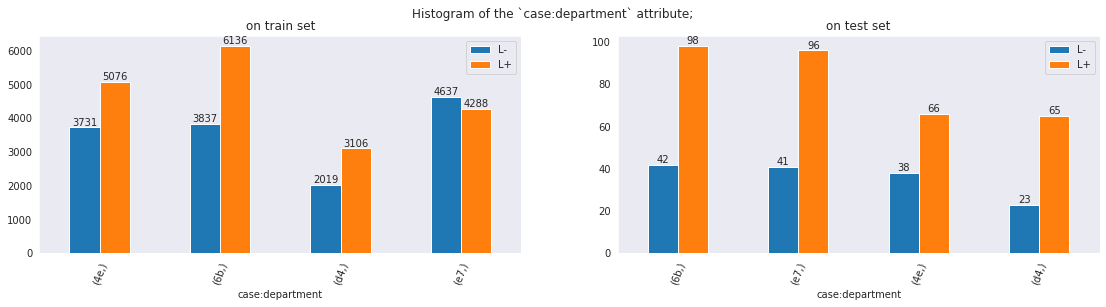

In [24]:
plot_hist_by_attr(df_lm_train, df_lm_test,
                  df_lp_train, df_lp_test, "case:department")

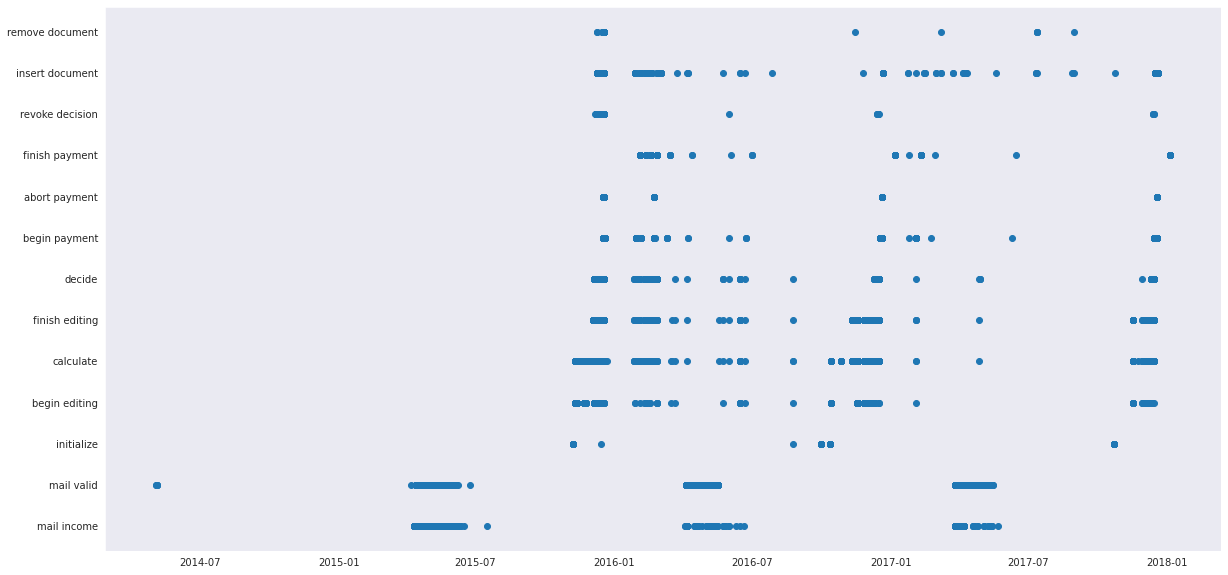

In [25]:
plt.figure(figsize=((20, 10)))
plt.scatter(df_lm_train['time:timestamp'], df_lm_train['concept:name'])

## <font color='green'> <b> Traffic </b> </font>

In [27]:
DATASET = 'Traffic'

# Load data and convert to pandas DataFrame
df_lm_train, df_lm_test, df_lp_train, df_lp_test = load_split_data_as_df(data_dir=DATA_DIR, dataset=DATASET, split_by=SPLIT_BY)

# Group by event names to get traces
lm_traces_train = df_lm_train[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lp_traces_train = df_lp_train[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lm_traces_test = df_lm_test[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lp_traces_test = df_lp_test[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']

[INFO]Loading 'Traffic' dataset from '../data/train_test_splits_unique'...


parsing log, completed traces ::   0%|          | 0/62175 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/33 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/17454 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/37 [00:00<?, ?it/s]

In [28]:
display(df_lm_train.head(2))
print_info(f"L- Train, shape: {df_lm_train.shape}")

display(df_lp_train.head(2))
print_info(f"L+ Train, shape: {df_lp_train.shape}")

display(df_lm_test.head(2))
print_info(f"L- Test, shape: {df_lm_test.shape}")

display(df_lp_test.head(2))
print_info(f"L+ Test, shape: {df_lp_test.shape}")

,points,article,totalPaymentAmount,vehicleClass,dismissal,org:resource,amount,time:timestamp,lifecycle:transition,concept:name,expense,lastSent,notificationType,paymentAmount,matricola,case:concept:name
0,0.0,157.0,0.0,A,NIL,561,35.0,2006-08-02 00:00:00+02:00,complete,Create Fine,NaN,NaN,NaN,NaN,NaN,A100
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-12-12 00:00:00+01:00,complete,Send Fine,11.0,NaN,NaN,NaN,NaN,A100


L- Train, shape: (317280, 16)


,points,article,totalPaymentAmount,vehicleClass,dismissal,org:resource,amount,time:timestamp,lifecycle:transition,concept:name,expense,lastSent,notificationType,paymentAmount,matricola,case:concept:name
0,0.0,157.0,0.0,A,NIL,561,36.0,2007-03-09 00:00:00+01:00,complete,Create Fine,NaN,NaN,NaN,NaN,NaN,A10000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-17 00:00:00+02:00,complete,Send Fine,13.0,NaN,NaN,NaN,NaN,A10000


L+ Train, shape: (96506, 16)


,points,article,totalPaymentAmount,vehicleClass,dismissal,org:resource,amount,time:timestamp,lifecycle:transition,concept:name,expense,lastSent,notificationType,paymentAmount,matricola,case:concept:name
0,0.0,157.0,0.0,A,NIL,561,35.0,2006-07-24 00:00:00+02:00,complete,Create Fine,NaN,NaN,NaN,NaN,NaN,A1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-12-05 00:00:00+01:00,complete,Send Fine,11.0,NaN,NaN,NaN,NaN,A1


L- Test, shape: (233, 16)


,points,article,totalPaymentAmount,vehicleClass,dismissal,org:resource,amount,time:timestamp,lifecycle:transition,concept:name,expense,lastSent,notificationType,paymentAmount,matricola,case:concept:name
0,0.0,157.0,0.0,A,NIL,537,36.0,2007-03-20 00:00:00+01:00,complete,Create Fine,NaN,NaN,NaN,NaN,NaN,A10005
1,NaN,NaN,36.0,NaN,NaN,NaN,NaN,2007-03-21 00:00:00+01:00,complete,Payment,NaN,NaN,NaN,36.0,NaN,A10005


L+ Test, shape: (296, 16)


          L-     L+
count  62175  17454
mean       5      5
std        0      0
min        3      3
50%        5      5
75%        5      6
99%        6      9
max       15     20


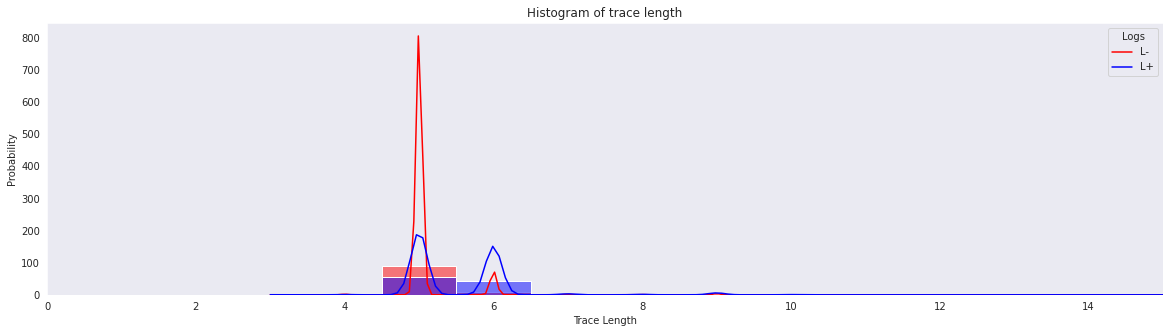

Unique event names in: 
Lminus(11 events): 
['Create Fine' 'Send Fine' 'Insert Fine Notification' 'Add penalty'
 'Send for Credit Collection' 'Insert Date Appeal to Prefecture'
 'Send Appeal to Prefecture' 'Payment'
 'Receive Result Appeal from Prefecture'
 'Notify Result Appeal to Offender' 'Appeal to Judge'] 

Lplus(10 events): 
['Create Fine' 'Send Fine' 'Insert Fine Notification' 'Add penalty'
 'Payment' 'Insert Date Appeal to Prefecture' 'Send Appeal to Prefecture'
 'Receive Result Appeal from Prefecture'
 'Notify Result Appeal to Offender' 'Appeal to Judge'] 

Their difference in terms of events: 
{'Send for Credit Collection'}


In [29]:
analyse_data(df_lm_train, df_lp_train, xlim=[0, 15])

       L-  L+
count  33  37
mean    7   8
std     2   2
min     2   2
50%     8   8
75%     9   9
99%    10  14
max    10  15


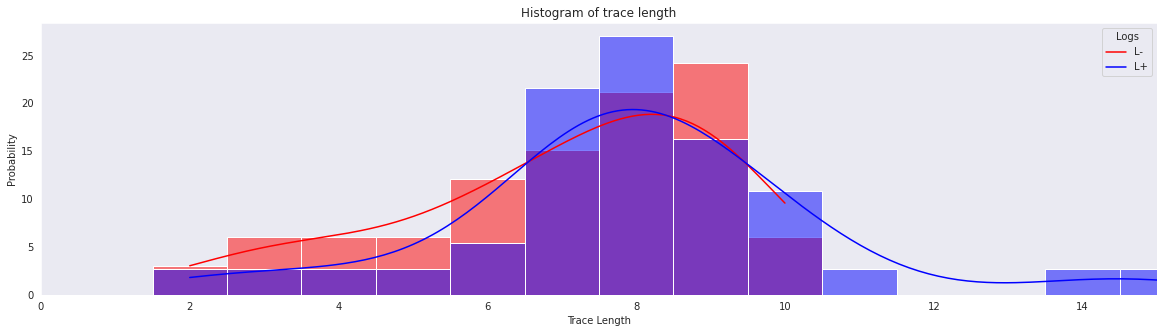

Unique event names in: 
Lminus(11 events): 
['Create Fine' 'Send Fine' 'Payment' 'Insert Fine Notification'
 'Add penalty' 'Send for Credit Collection'
 'Insert Date Appeal to Prefecture'
 'Receive Result Appeal from Prefecture'
 'Notify Result Appeal to Offender' 'Appeal to Judge'
 'Send Appeal to Prefecture'] 

Lplus(10 events): 
['Create Fine' 'Payment' 'Send Fine' 'Insert Fine Notification'
 'Add penalty' 'Insert Date Appeal to Prefecture'
 'Send Appeal to Prefecture' 'Receive Result Appeal from Prefecture'
 'Notify Result Appeal to Offender' 'Appeal to Judge'] 

Their difference in terms of events: 
{'Send for Credit Collection'}


In [30]:
analyse_data(df_lm_test, df_lp_test, xlim=[0, 15])

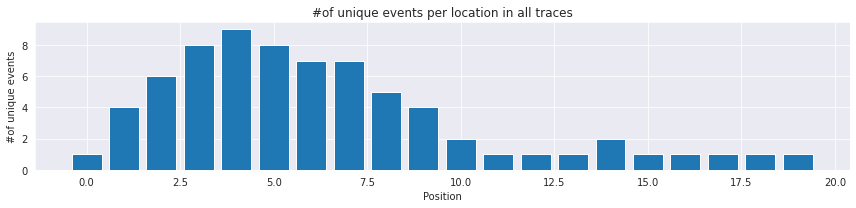

In [31]:
plot_unique_events_per_trace_location(lm_traces_train, lm_traces_test, 
                                      lp_traces_train, lp_traces_test)

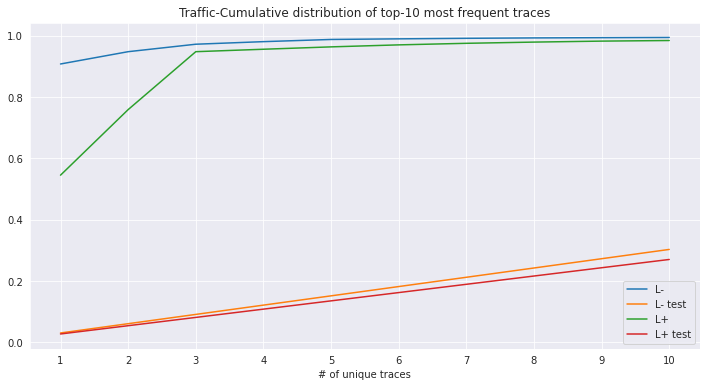

In [32]:
plot_cumulative_dist_of_traces(lm_traces_train, lm_traces_test, 
                               lp_traces_train, lp_traces_test,
                               dataset=DATASET, top_k=10)

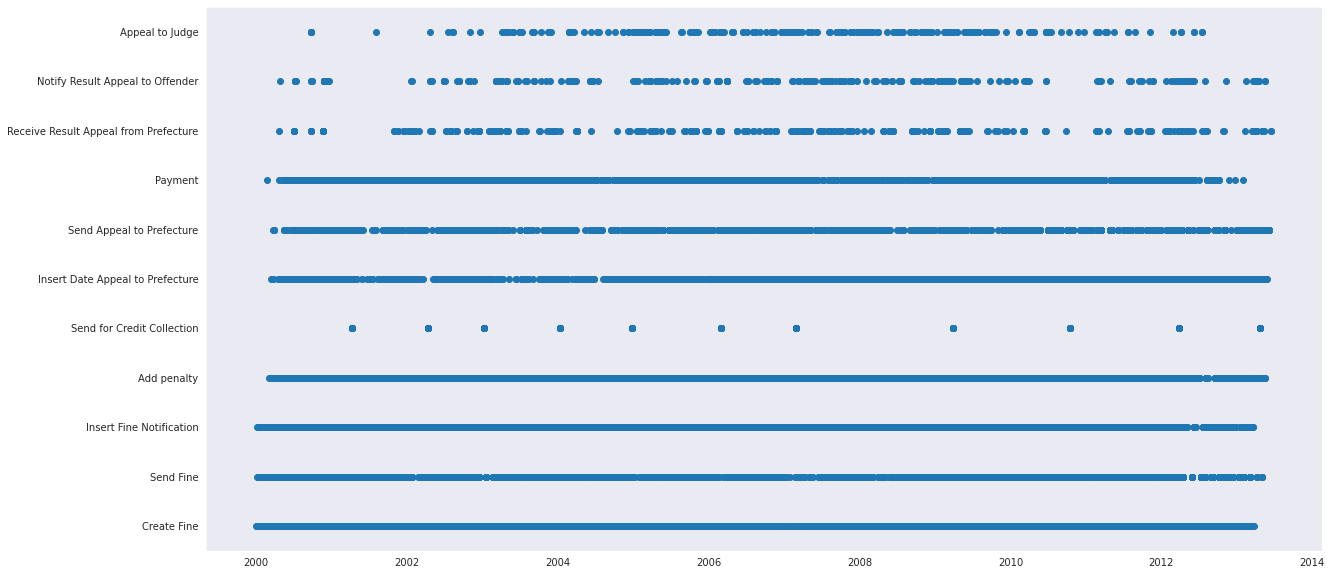

In [33]:
plt.figure(figsize=((20, 10)))
plt.scatter(df_lm_train['time:timestamp'], df_lm_train['concept:name'])

## <font color='green'> <b> COVID </b> </font>

In [35]:
DATASET = 'COVID'

# Load data and convert to pandas DataFrame
df_lm_train, df_lm_test, df_lp_train, df_lp_test = load_split_data_as_df(data_dir=DATA_DIR, dataset=DATASET, split_by=SPLIT_BY)

# Group by event names to get traces
lm_traces_train = df_lm_train[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lp_traces_train = df_lp_train[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lm_traces_test = df_lm_test[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lp_traces_test = df_lp_test[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']

[INFO]Loading 'COVID' dataset from '../data/train_test_splits_unique'...


parsing log, completed traces ::   0%|          | 0/42 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/114 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
display(df_lm_train.head(2))
print_info(f"L- Train, shape: {df_lm_train.shape}")

display(df_lp_train.head(2))
print_info(f"L+ Train, shape: {df_lp_train.shape}")

display(df_lm_test.head(2))
print_info(f"L- Test, shape: {df_lm_test.shape}")

display(df_lp_test.head(2))
print_info(f"L+ Test, shape: {df_lp_test.shape}")

,Age,Katecholamine,Sex,Outcome,Antibiotics,Group,concept:name,lifecycle:transition,time:timestamp,FeverDays,PronePos,CVVH,ECMO,ECMODays,Deaxamethason,Plasma,Remdesivir,case:concept:name
0,77,x,m,dead,x,ARDS,startSymptoms,start,2020-04-07 00:02:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1201988230
1,77,x,m,dead,x,ARDS,Hospitalization,start,2020-04-07 00:10:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1201988230


L- Train, shape: (355, 18)


,Age,Sex,Outcome,Antibiotics,Group,concept:name,lifecycle:transition,time:timestamp,FeverDays,Katecholamine,PronePos,CVVH,ECMO,ECMODays,Remdesivir,Deaxamethason,Plasma,case:concept:name
0,81,m,alive,x,non ARDS,startSymptoms,start,2020-03-17 00:02:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1202004080
1,81,m,alive,x,non ARDS,Hospitalization,start,2020-03-18 00:10:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1202004080


L+ Train, shape: (801, 18)


,Age,Katecholamine,Sex,Outcome,Antibiotics,Group,concept:name,lifecycle:transition,time:timestamp,FeverDays,PronePos,CVVH,ECMO,ECMODays,Deaxamethason,Plasma,Remdesivir,case:concept:name
0,88,x,w,dead,NaN,ARDS,startSymptoms,start,2020-03-16 00:02:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1202200024
1,88,x,w,dead,NaN,ARDS,Hospitalization,start,2020-03-16 00:10:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1202200024


L- Test, shape: (68, 18)


,Age,Sex,Outcome,Antibiotics,Group,concept:name,lifecycle:transition,time:timestamp,FeverDays,Katecholamine,PronePos,CVVH,ECMO,ECMODays,Remdesivir,Deaxamethason,Plasma,case:concept:name
0,59,m,alive,x,ARDS,startSymptoms,start,2020-03-01 00:02:00+01:00,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,1202189420
1,59,m,alive,x,ARDS,Hospitalization,start,2020-03-06 00:10:00+01:00,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,1202189420


L+ Test, shape: (64, 18)


       L-   L+
count  42  114
mean    8    7
std     2    2
min     5    3
50%    10    6
75%    10    8
99%    12   12
max    12   12


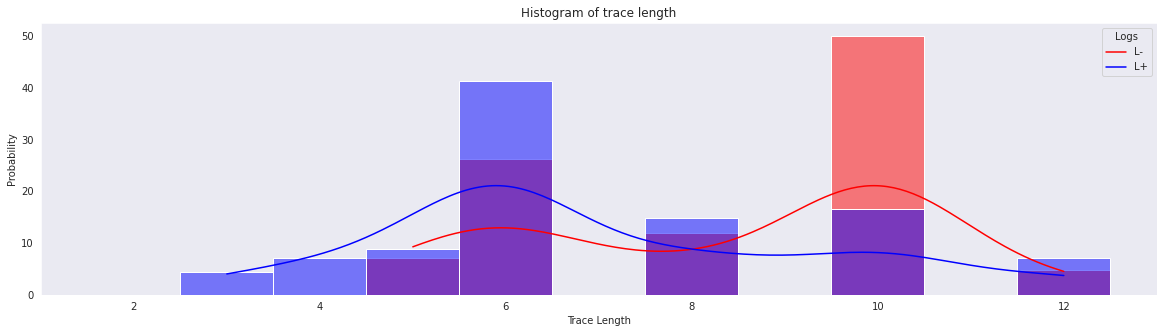

Unique event names in: 
Lminus(12 events): 
['startSymptoms' 'Hospitalization' 'startOxygen' 'ICU admission'
 'startVentilation' 'endOxygen' 'endVentilation' 'ICU discharge'
 'endSymptoms' 'Discharge dead' 'startECMO' 'endECMO'] 

Lplus(12 events): 
['startSymptoms' 'Hospitalization' 'startOxygen' 'endSymptoms' 'endOxygen'
 'Discharge alive' 'ICU admission' 'startVentilation' 'startECMO'
 'endECMO' 'endVentilation' 'ICU discharge'] 

Their difference in terms of events: 
{'Discharge alive', 'Discharge dead'}


In [37]:
analyse_data(df_lm_train, df_lp_train, xlim=[1, 13])

       L-  L+
count   6  10
mean   11   6
std     1   2
min    10   2
50%    12   6
75%    12   9
99%    12  10
max    12  10


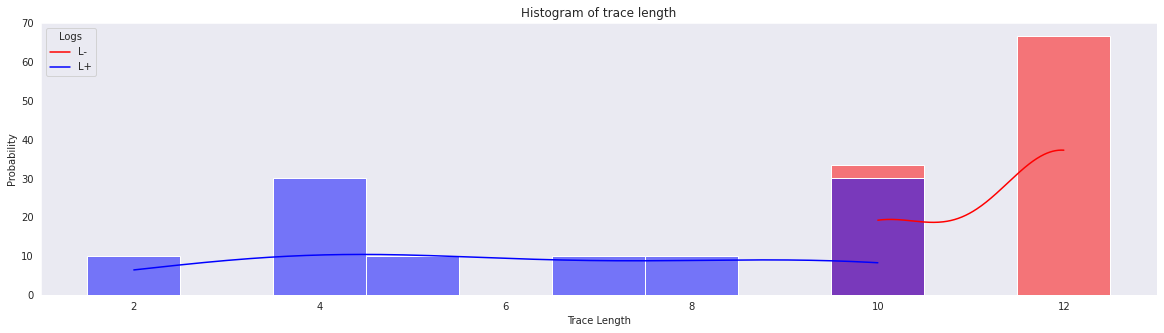

Unique event names in: 
Lminus(12 events): 
['startSymptoms' 'Hospitalization' 'startOxygen' 'ICU admission'
 'startVentilation' 'endVentilation' 'endOxygen' 'ICU discharge'
 'endSymptoms' 'Discharge dead' 'startECMO' 'endECMO'] 

Lplus(10 events): 
['startSymptoms' 'Hospitalization' 'startOxygen' 'ICU admission'
 'startVentilation' 'endOxygen' 'endVentilation' 'endSymptoms'
 'ICU discharge' 'Discharge alive'] 

Their difference in terms of events: 
{'startECMO', 'Discharge alive', 'Discharge dead', 'endECMO'}


In [38]:
analyse_data(df_lm_test, df_lp_test, xlim=[1, 13])

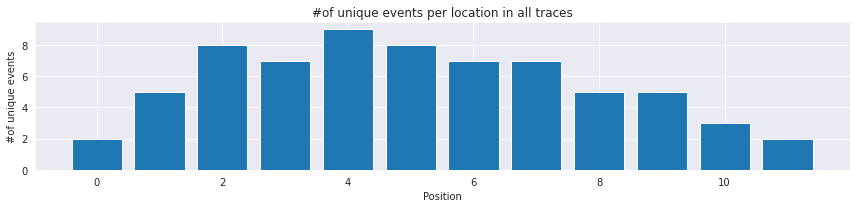

In [39]:
plot_unique_events_per_trace_location(lm_traces_train, lm_traces_test, 
                                      lp_traces_train, lp_traces_test)

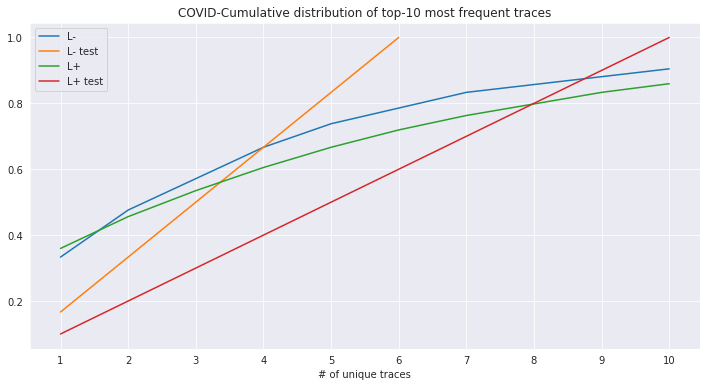

In [40]:
plot_cumulative_dist_of_traces(lm_traces_train, lm_traces_test, 
                               lp_traces_train, lp_traces_test,
                               dataset=DATASET, top_k=10)

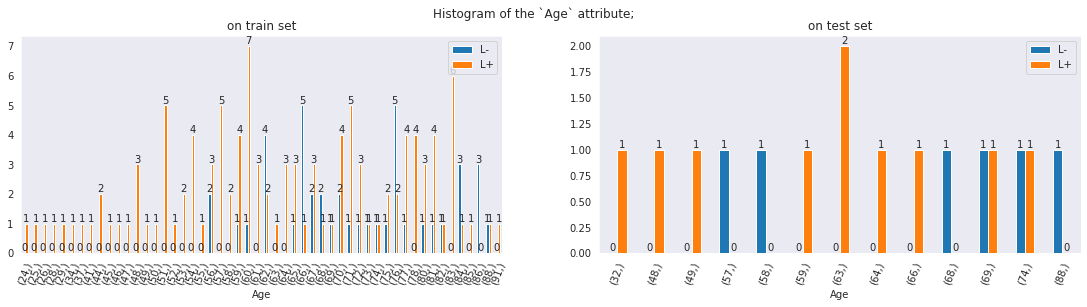

In [41]:
plot_hist_by_attr(df_lm_train, df_lm_test,
                  df_lp_train, df_lp_test, "Age")

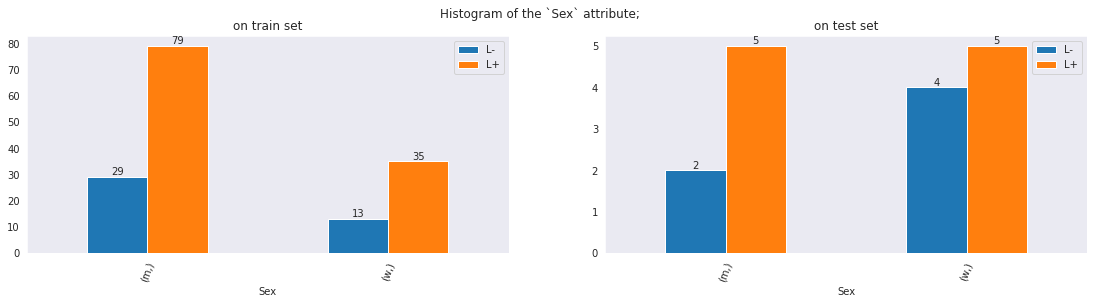

In [42]:
plot_hist_by_attr(df_lm_train, df_lm_test,
                  df_lp_train, df_lp_test, "Sex")

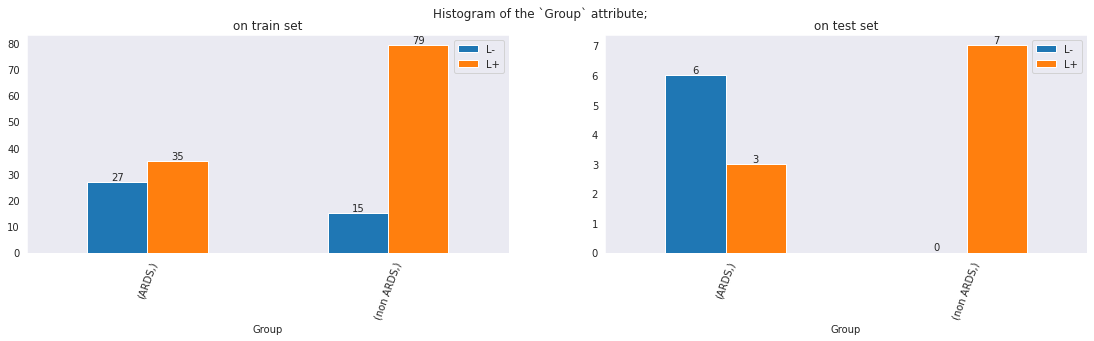

In [43]:
plot_hist_by_attr(df_lm_train, df_lm_test,
                  df_lp_train, df_lp_test, "Group")

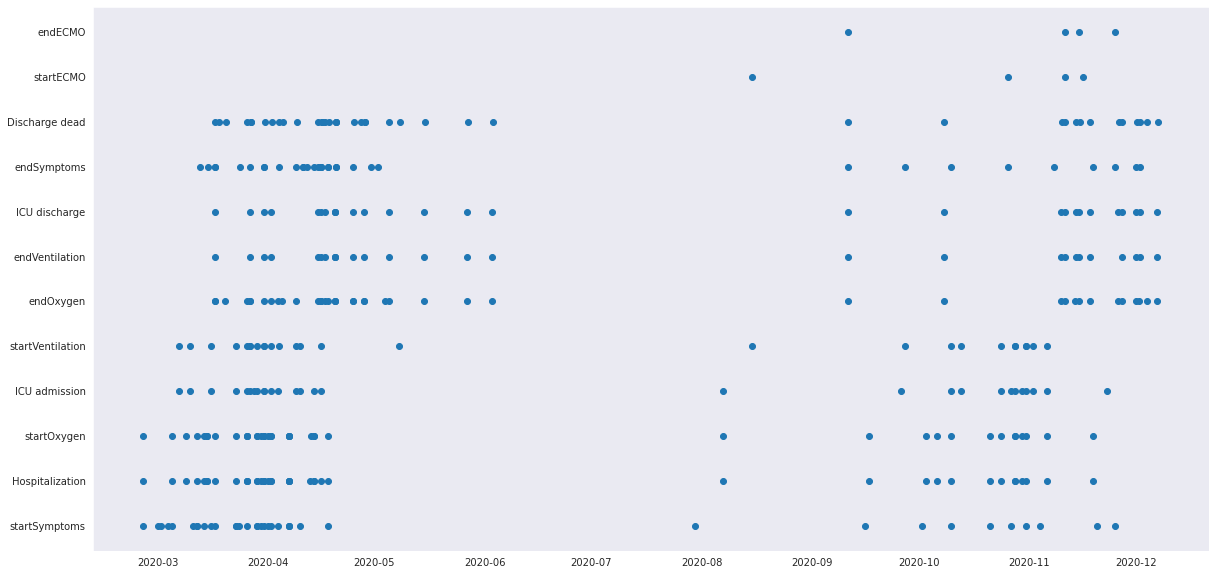

In [44]:
plt.figure(figsize=((20, 10)))
plt.scatter(df_lm_train['time:timestamp'], df_lm_train['concept:name'])

## <font color='green'> <b> Hospital </b> </font>

In [46]:
DATASET = 'Hospital'

# Load data and convert to pandas DataFrame
df_lm_train, df_lm_test, df_lp_train, df_lp_test = load_split_data_as_df(data_dir=DATA_DIR, dataset=DATASET, split_by=SPLIT_BY)

# Group by event names to get traces
lm_traces_train = df_lm_train[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lp_traces_train = df_lp_train[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lm_traces_test = df_lm_test[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']
lp_traces_test = df_lp_test[['concept:name', "case:concept:name"]].groupby('case:concept:name').agg(','.join)['concept:name']

[INFO]Loading 'Hospital' dataset from '../data/train_test_splits_unique'...


parsing log, completed traces ::   0%|          | 0/25402 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/266 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/31065 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/92 [00:00<?, ?it/s]

In [47]:
display(df_lm_train.head(2))
print_info(f"L- Train, shape: {df_lm_train.shape}")

display(df_lp_train.head(2))
print_info(f"L+ Train, shape: {df_lp_train.shape}")

display(df_lm_test.head(2))
print_info(f"L- Test, shape: {df_lm_test.shape}")

display(df_lp_test.head(2))
print_info(f"L+ Test, shape: {df_lp_test.shape}")

,state,flagA,flagB,flagD,isClosed,blocked,org:resource,speciality,caseType,diagnosis,...,concept:name,closeCode,version,msgCount,flagC,actOrange,actRed,msgCode,msgType,case:concept:name
0,In progress,False,False,True,True,False,ResA,A,A,A,...,NEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
1,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,FIN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A


L- Train, shape: (140692, 23)


,state,flagA,flagB,flagD,isClosed,blocked,org:resource,speciality,caseType,diagnosis,...,concept:name,closeCode,version,msgCount,flagC,actOrange,actRed,msgCode,msgType,case:concept:name
0,In progress,False,False,True,True,False,ResQ,E,B,NaN,...,NEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,...,FIN,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


L+ Train, shape: (61666, 23)


,state,flagA,flagB,flagD,isClosed,blocked,org:resource,speciality,caseType,diagnosis,...,concept:name,closeCode,version,msgCount,flagC,actOrange,actRed,msgCode,msgType,case:concept:name
0,In progress,False,False,True,True,False,ResHA,L,B,NaN,...,NEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AA
1,In progress,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,...,CHANGE DIAGN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AA


L- Test, shape: (3284, 23)


,state,flagA,flagB,flagD,isClosed,blocked,org:resource,speciality,caseType,diagnosis,...,concept:name,closeCode,version,msgCount,flagC,actOrange,actRed,msgCode,msgType,case:concept:name
0,In progress,False,False,True,False,False,ResSG,A,B,NaN,...,NEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AR
1,In progress,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HI,...,CHANGE DIAGN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AR


L+ Test, shape: (878, 23)


In [48]:
df_lp_test.columns

Index(['state', 'flagA', 'flagB', 'flagD', 'isClosed', 'blocked',
       'org:resource', 'speciality', 'caseType', 'diagnosis', 'isCancelled',
       'time:timestamp', 'lifecycle:transition', 'concept:name', 'closeCode',
       'version', 'msgCount', 'flagC', 'actOrange', 'actRed', 'msgCode',
       'msgType', 'case:concept:name'],
      dtype='object')

          L-     L+
count  25402  31065
mean       5      1
std        2      1
min        2      1
50%        5      1
75%        5      2
99%       14      9
max      217     52


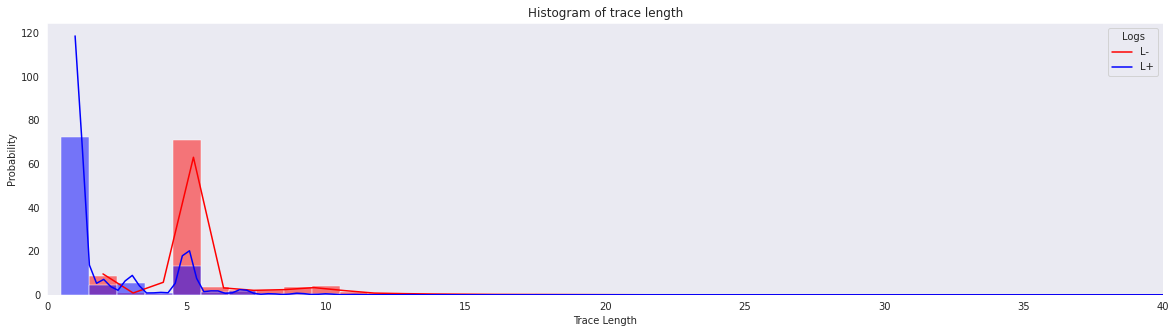

Unique event names in: 
Lminus(17 events): 
['NEW' 'FIN' 'RELEASE' 'CODE OK' 'BILLED' 'REOPEN' 'CHANGE DIAGN' 'STORNO'
 'REJECT' 'CODE NOK' 'DELETE' 'SET STATUS' 'CHANGE END' 'MANUAL'
 'JOIN-PAT' 'CODE ERROR' 'EMPTY'] 

Lplus(18 events): 
['NEW' 'FIN' 'RELEASE' 'CODE OK' 'BILLED' 'CHANGE DIAGN' 'DELETE'
 'SET STATUS' 'REOPEN' 'STORNO' 'REJECT' 'JOIN-PAT' 'CODE NOK'
 'CHANGE END' 'MANUAL' 'ZDBC_BEHAN' 'CODE ERROR' 'EMPTY'] 

Their difference in terms of events: 
{'ZDBC_BEHAN'}


In [49]:
analyse_data(df_lm_train, df_lp_train, xlim=[0, 40])

        L-   L+
count  266   92
mean    12    9
std     10   18
min      2    2
50%     11    7
75%     14    9
99%     29   44
max    157  176


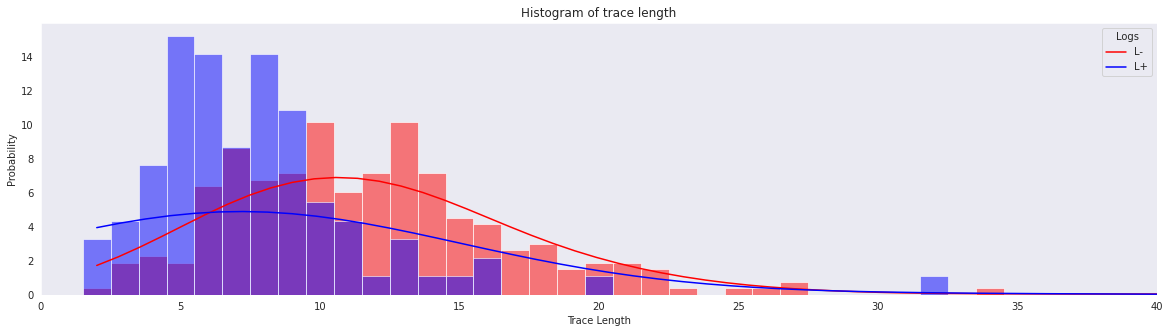

Unique event names in: 
Lminus(17 events): 
['NEW' 'CHANGE DIAGN' 'FIN' 'RELEASE' 'CODE OK' 'BILLED' 'STORNO' 'REJECT'
 'REOPEN' 'CODE NOK' 'SET STATUS' 'DELETE' 'JOIN-PAT' 'MANUAL'
 'CODE ERROR' 'CHANGE END' 'EMPTY'] 

Lplus(16 events): 
['NEW' 'CHANGE DIAGN' 'DELETE' 'FIN' 'RELEASE' 'BILLED' 'STORNO' 'REJECT'
 'REOPEN' 'JOIN-PAT' 'SET STATUS' 'CODE OK' 'CHANGE END' 'CODE NOK'
 'MANUAL' 'EMPTY'] 

Their difference in terms of events: 
{'CODE ERROR'}


In [50]:
analyse_data(df_lm_test, df_lp_test, xlim=[0, 40])

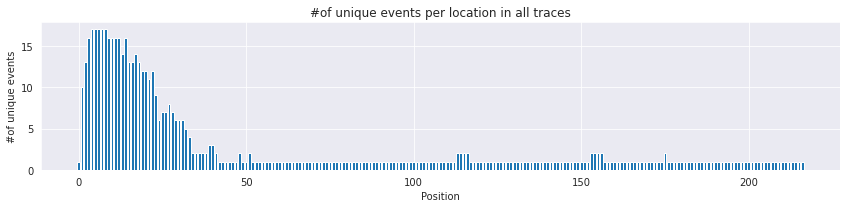

In [51]:
plot_unique_events_per_trace_location(lm_traces_train, lm_traces_test, 
                                      lp_traces_train, lp_traces_test)

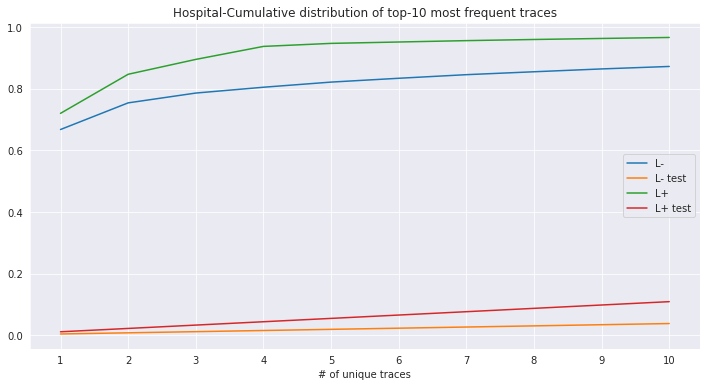

In [52]:
plot_cumulative_dist_of_traces(lm_traces_train, lm_traces_test, 
                               lp_traces_train, lp_traces_test,
                               dataset=DATASET, top_k=10)

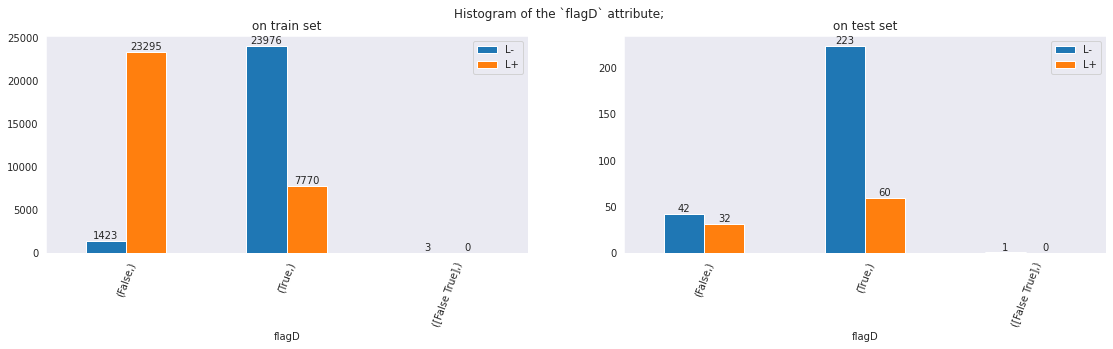

In [53]:
plot_hist_by_attr(df_lm_train, df_lm_test,
                  df_lp_train, df_lp_test, "flagD")

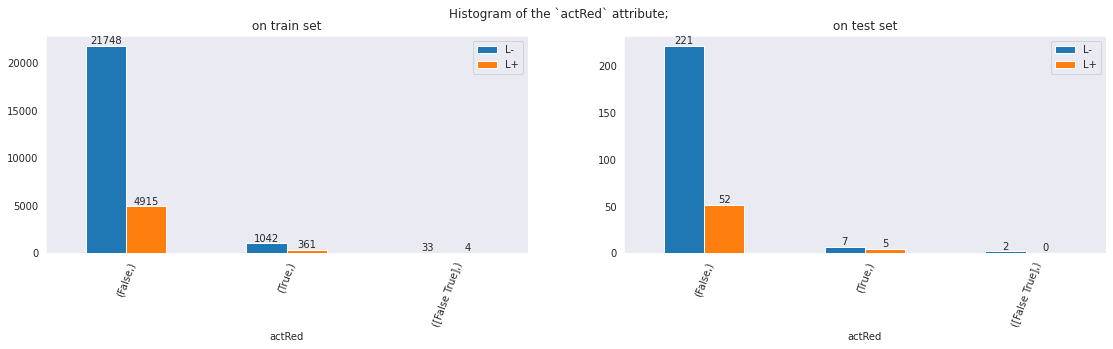

In [54]:
plot_hist_by_attr(df_lm_train, df_lm_test,
                  df_lp_train, df_lp_test, "actRed")

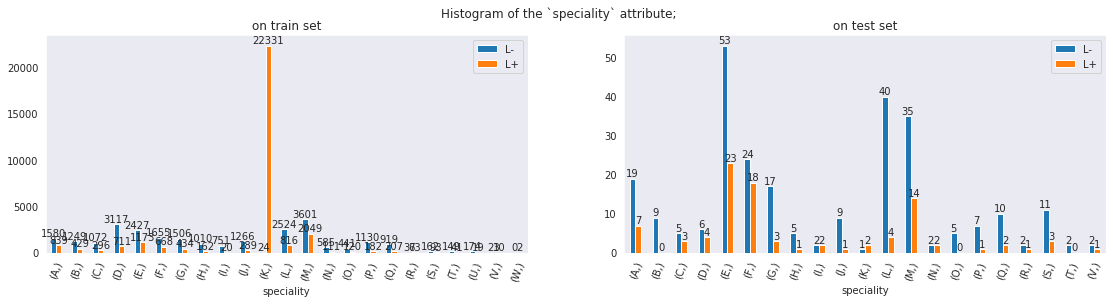

In [55]:
plot_hist_by_attr(df_lm_train, df_lm_test,
                  df_lp_train, df_lp_test, "speciality")

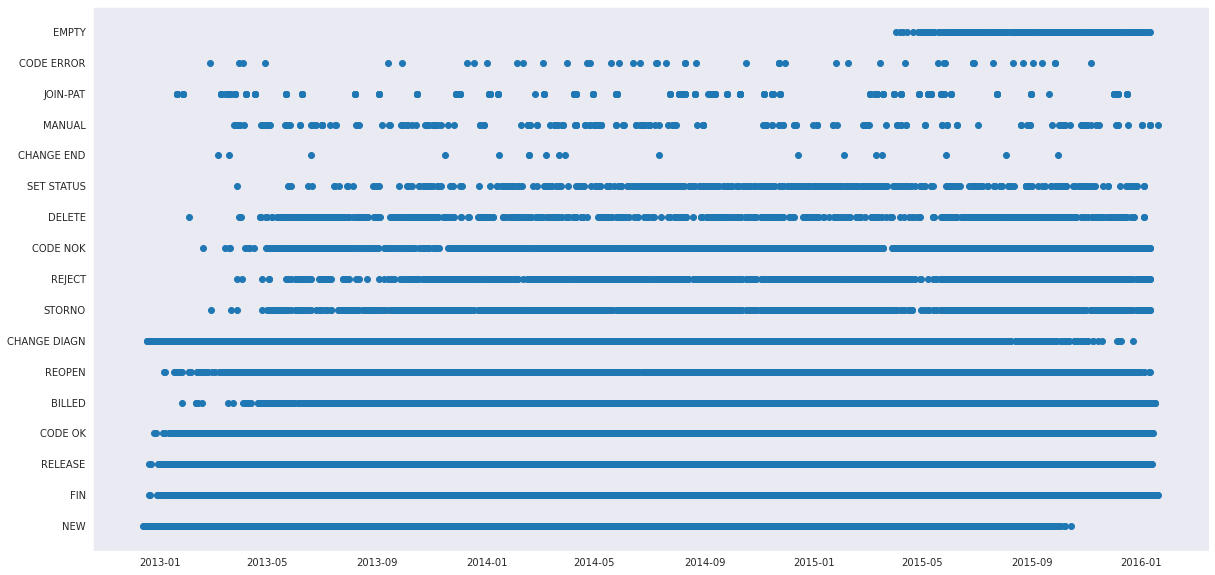

In [56]:
plt.figure(figsize=((20, 10)))
plt.scatter(df_lm_train['time:timestamp'], df_lm_train['concept:name'])

# <font color='green'> <b> Process Model Discovery </b> </font>

In [58]:
import pm4py
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

### Covid

parsing log, completed traces ::   0%|          | 0/60 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/136 [00:00<?, ?it/s]

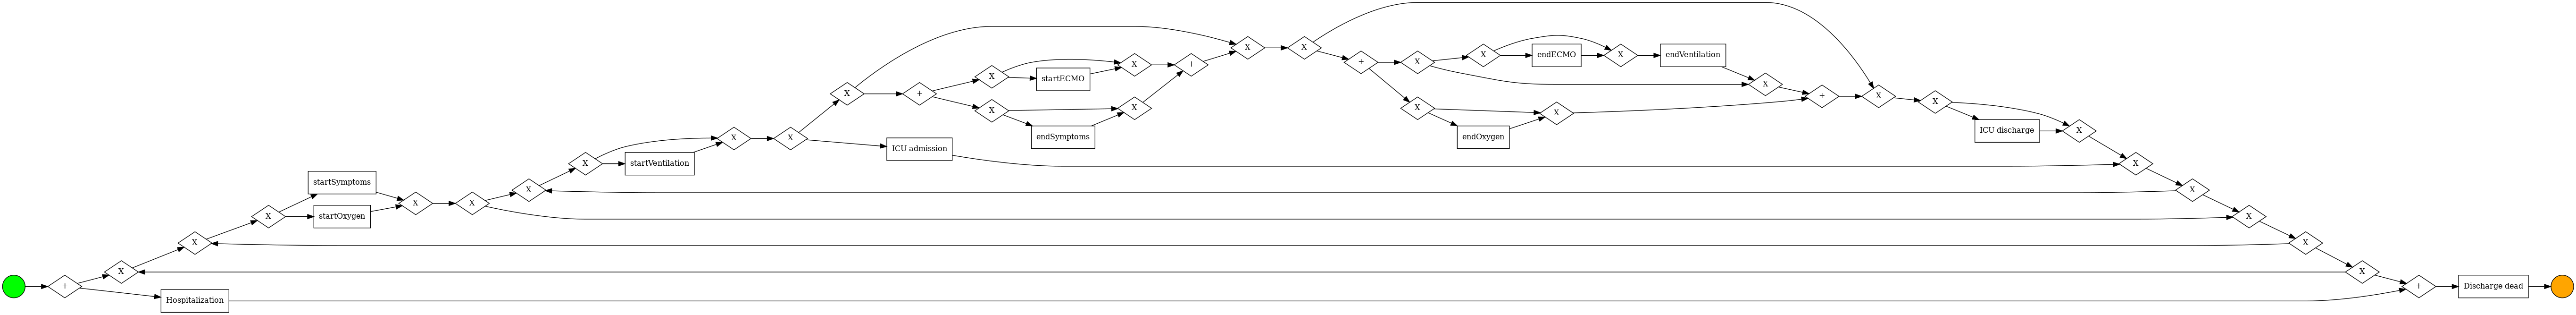

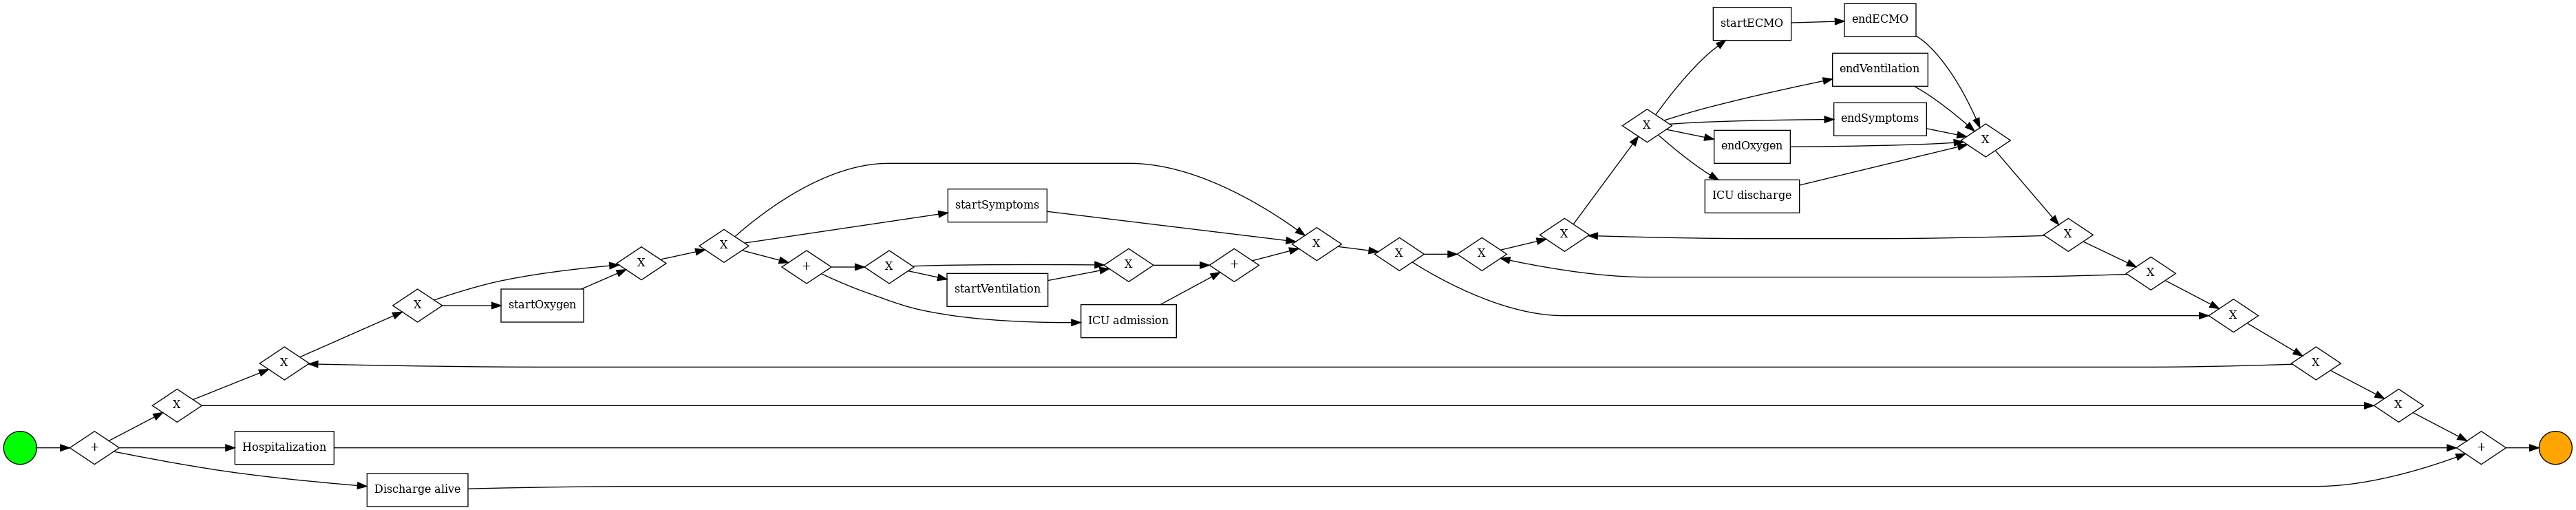

In [59]:
# Load an example log
log_lm = pm4py.read_xes(f"{DATA_DIR}COVID/Lm_final.xes")
log_lp = pm4py.read_xes(f"{DATA_DIR}COVID/Lp_final.xes")

# Discover models for both logs
model_lm = pm4py.discover_bpmn_inductive(log_lm)
pm4py.view_bpmn(model_lm)

model_lp = pm4py.discover_bpmn_inductive(log_lp)
pm4py.view_bpmn(model_lp)

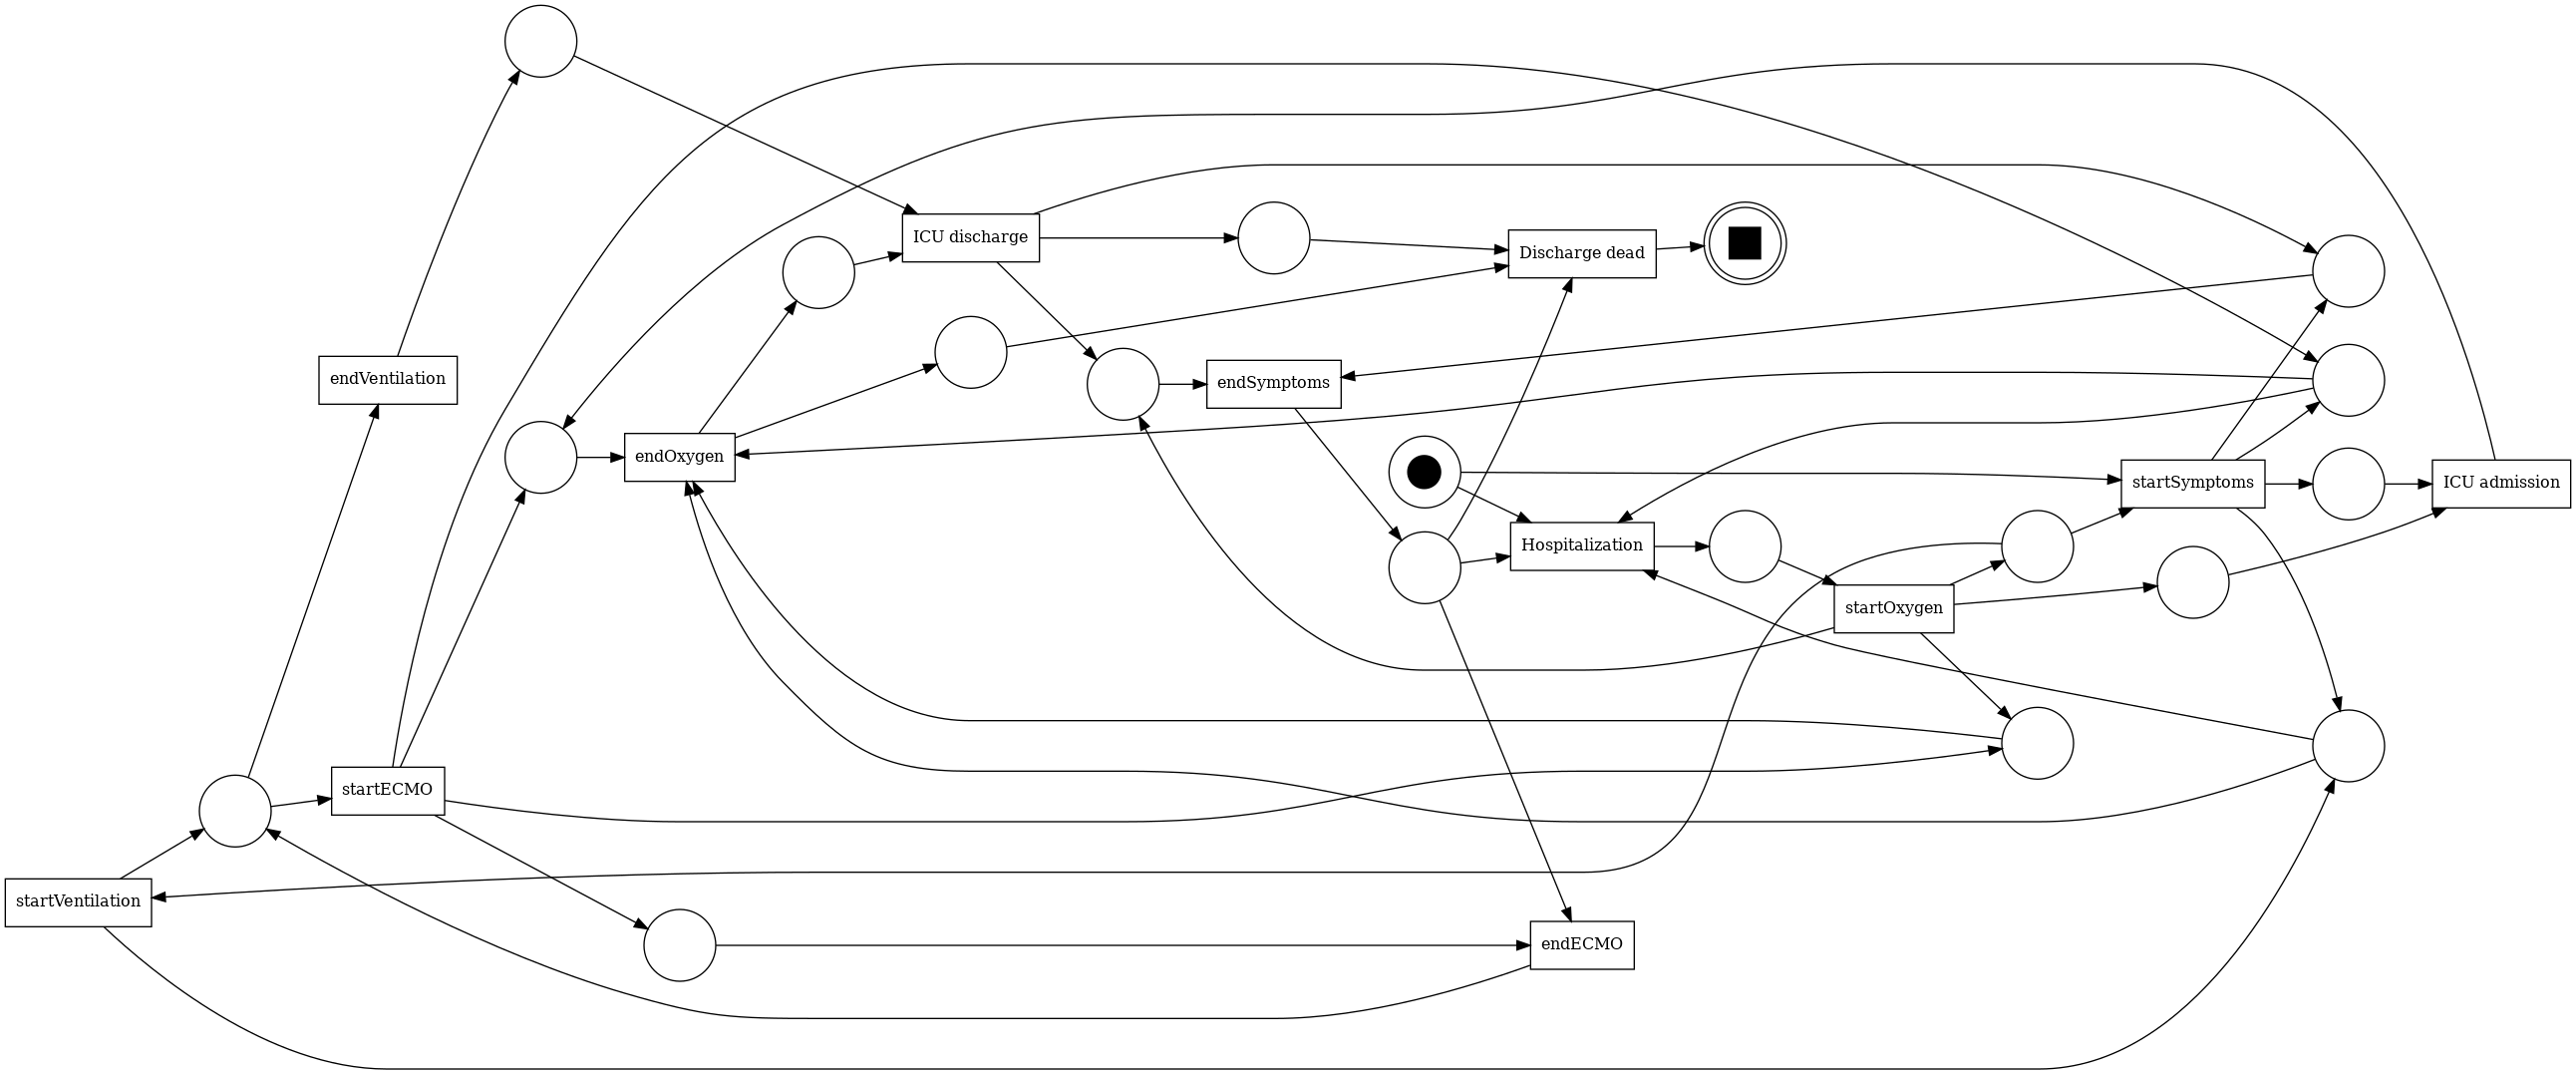

In [60]:
'Alpha Miner'
# Apply the algorithm
net, initial_marking, final_marking = alpha_miner.apply(log_lm)
# Visualize the petri net
pm4py.view_petri_net(net, initial_marking=initial_marking, final_marking=final_marking)

### Traffic

parsing log, completed traces ::   0%|          | 0/83169 [00:00<?, ?it/s]

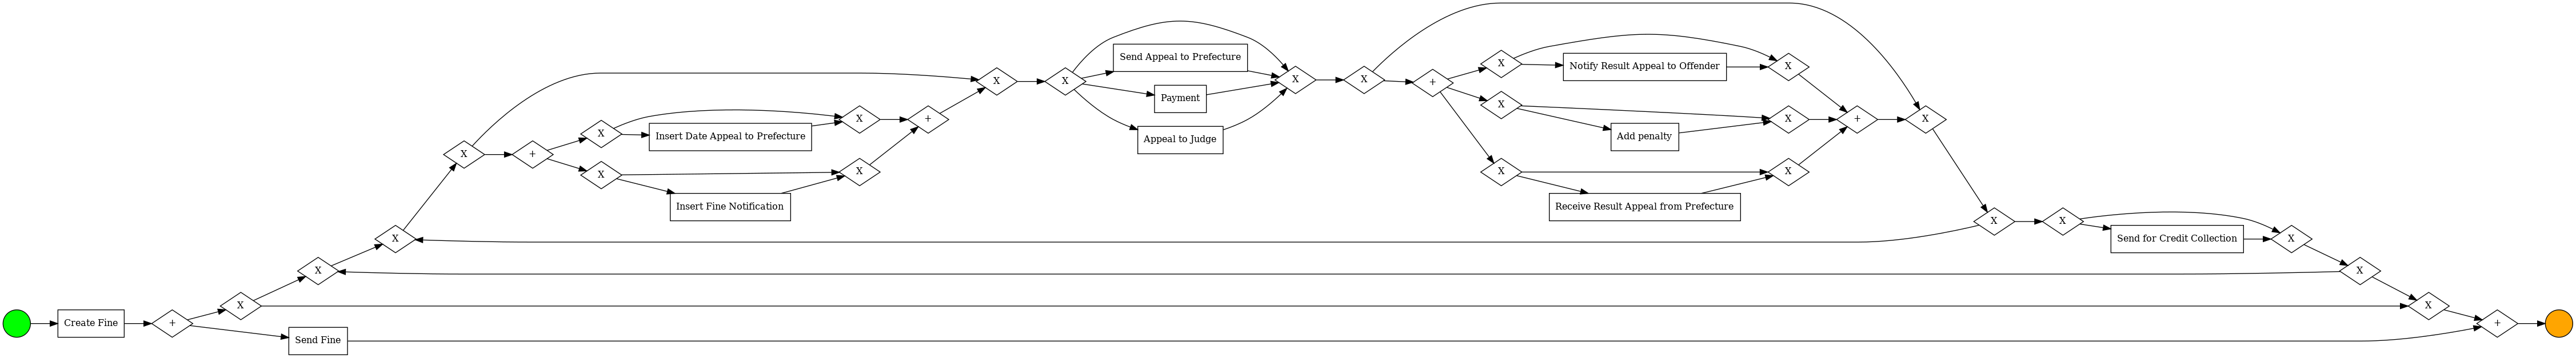

In [61]:
# Load an example log
log = pm4py.read_xes(f"{DATA_DIR}Traffic/Lm_final.xes")
# Discover model
model = pm4py.discover_bpmn_inductive(log)
pm4py.view_bpmn(model)

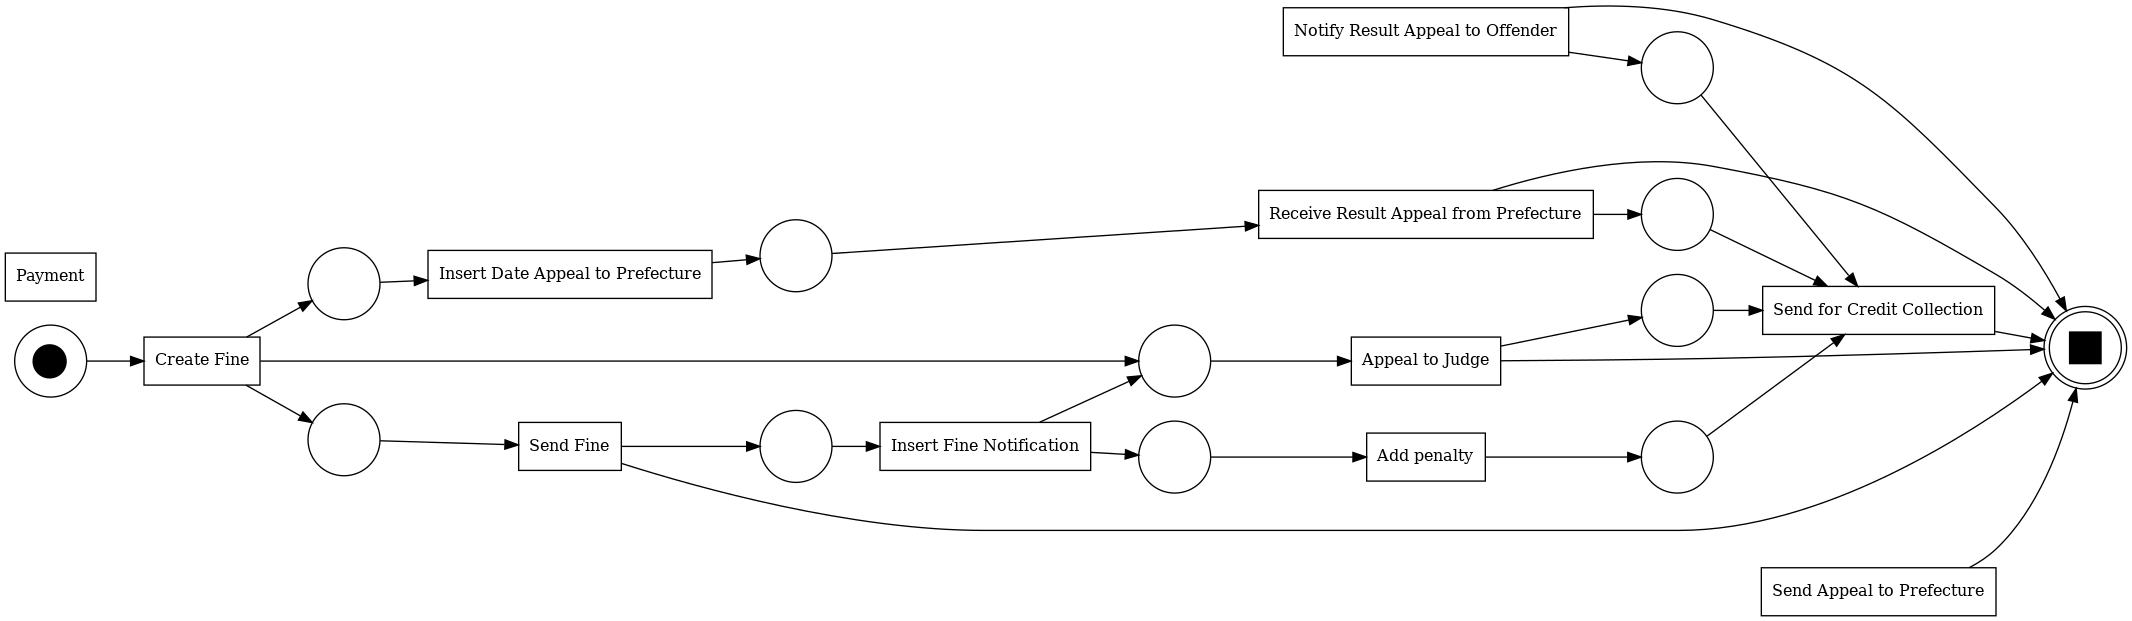

In [62]:
'Alpha Miner'
# Apply the algorithm
net, initial_marking, final_marking = alpha_miner.apply(log)
# Visualize the petri net
pm4py.view_petri_net(net, initial_marking=initial_marking, final_marking=final_marking)

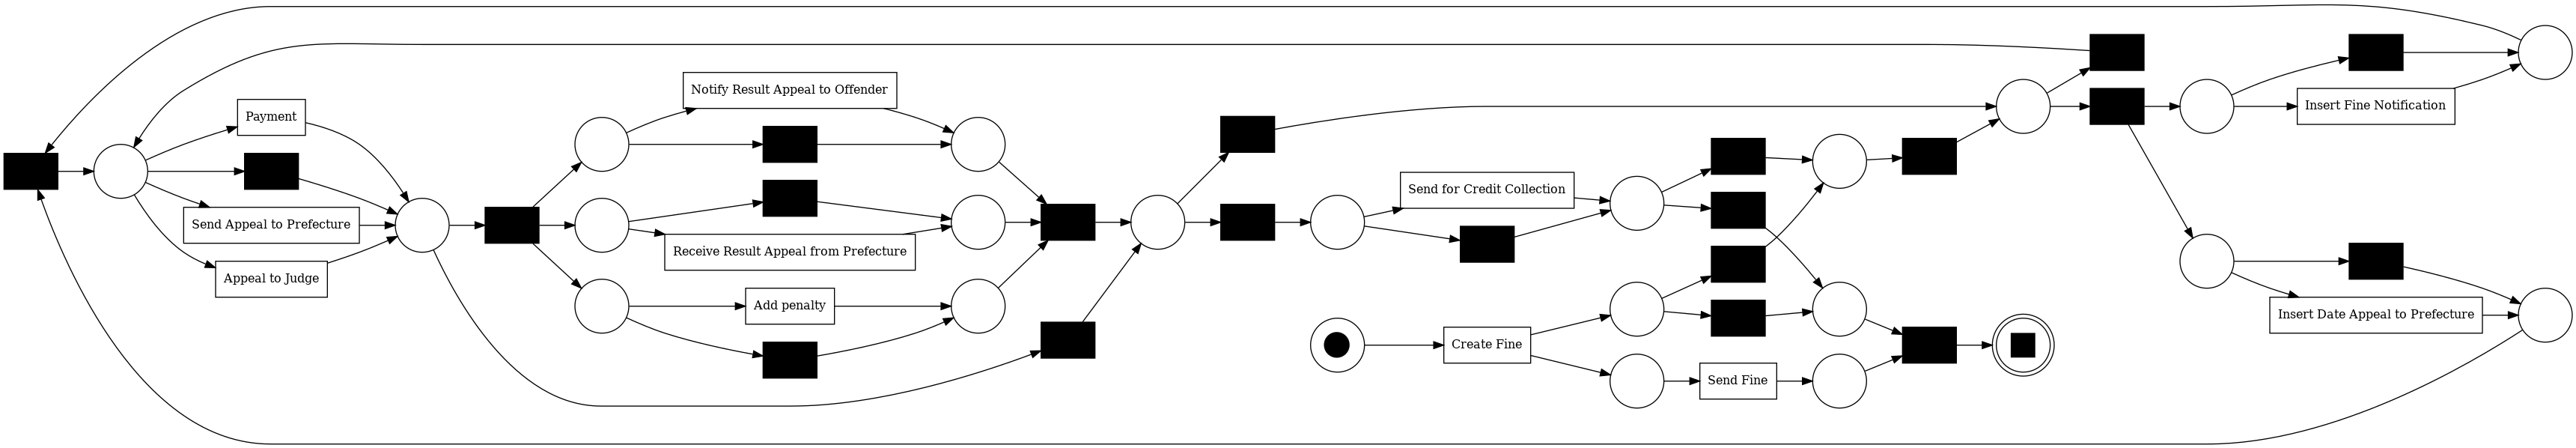

In [63]:
'Inductive Miner'
# Apply the algorithm
net, initial_marking, final_marking = inductive_miner.apply(log)
# Visualize the petri net
pm4py.view_petri_net(net, initial_marking=initial_marking, final_marking=final_marking)

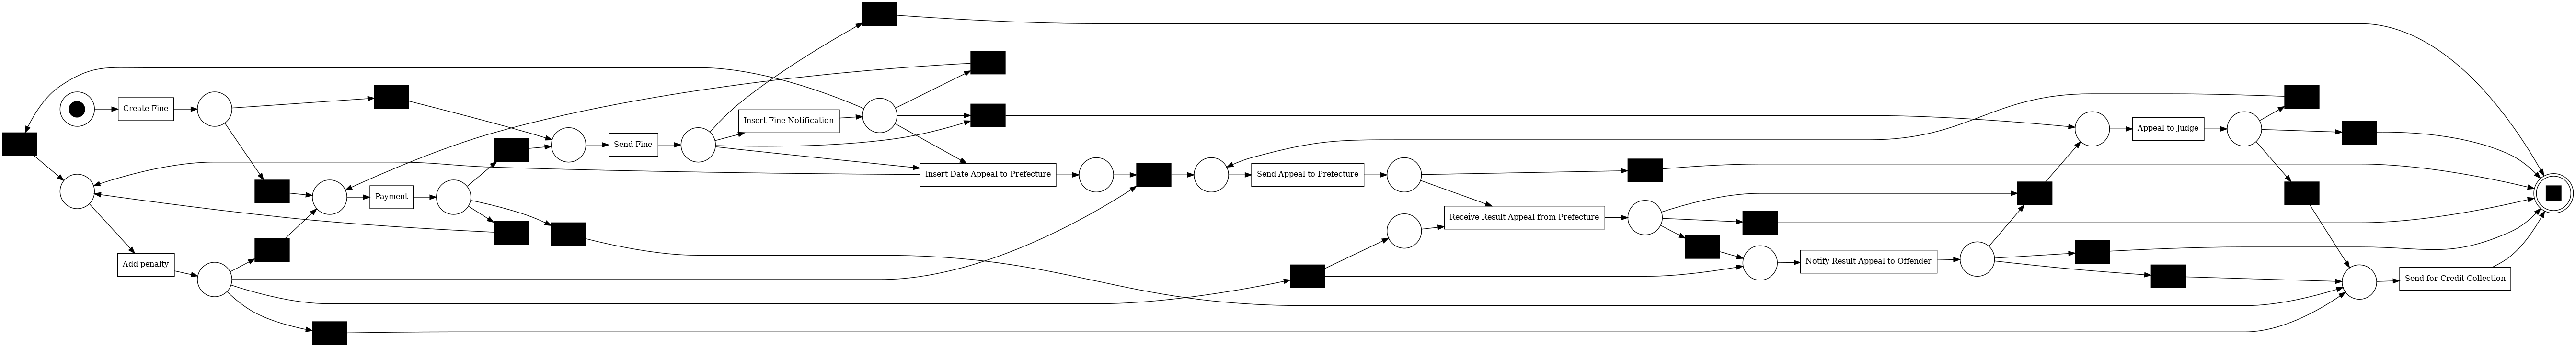

In [64]:
'Heuristics Miner'
# Apply the algorithm
net, initial_marking, final_marking = heuristics_miner.apply(log)
# Visualize the petri net
pm4py.view_petri_net(net, initial_marking=initial_marking, final_marking=final_marking)

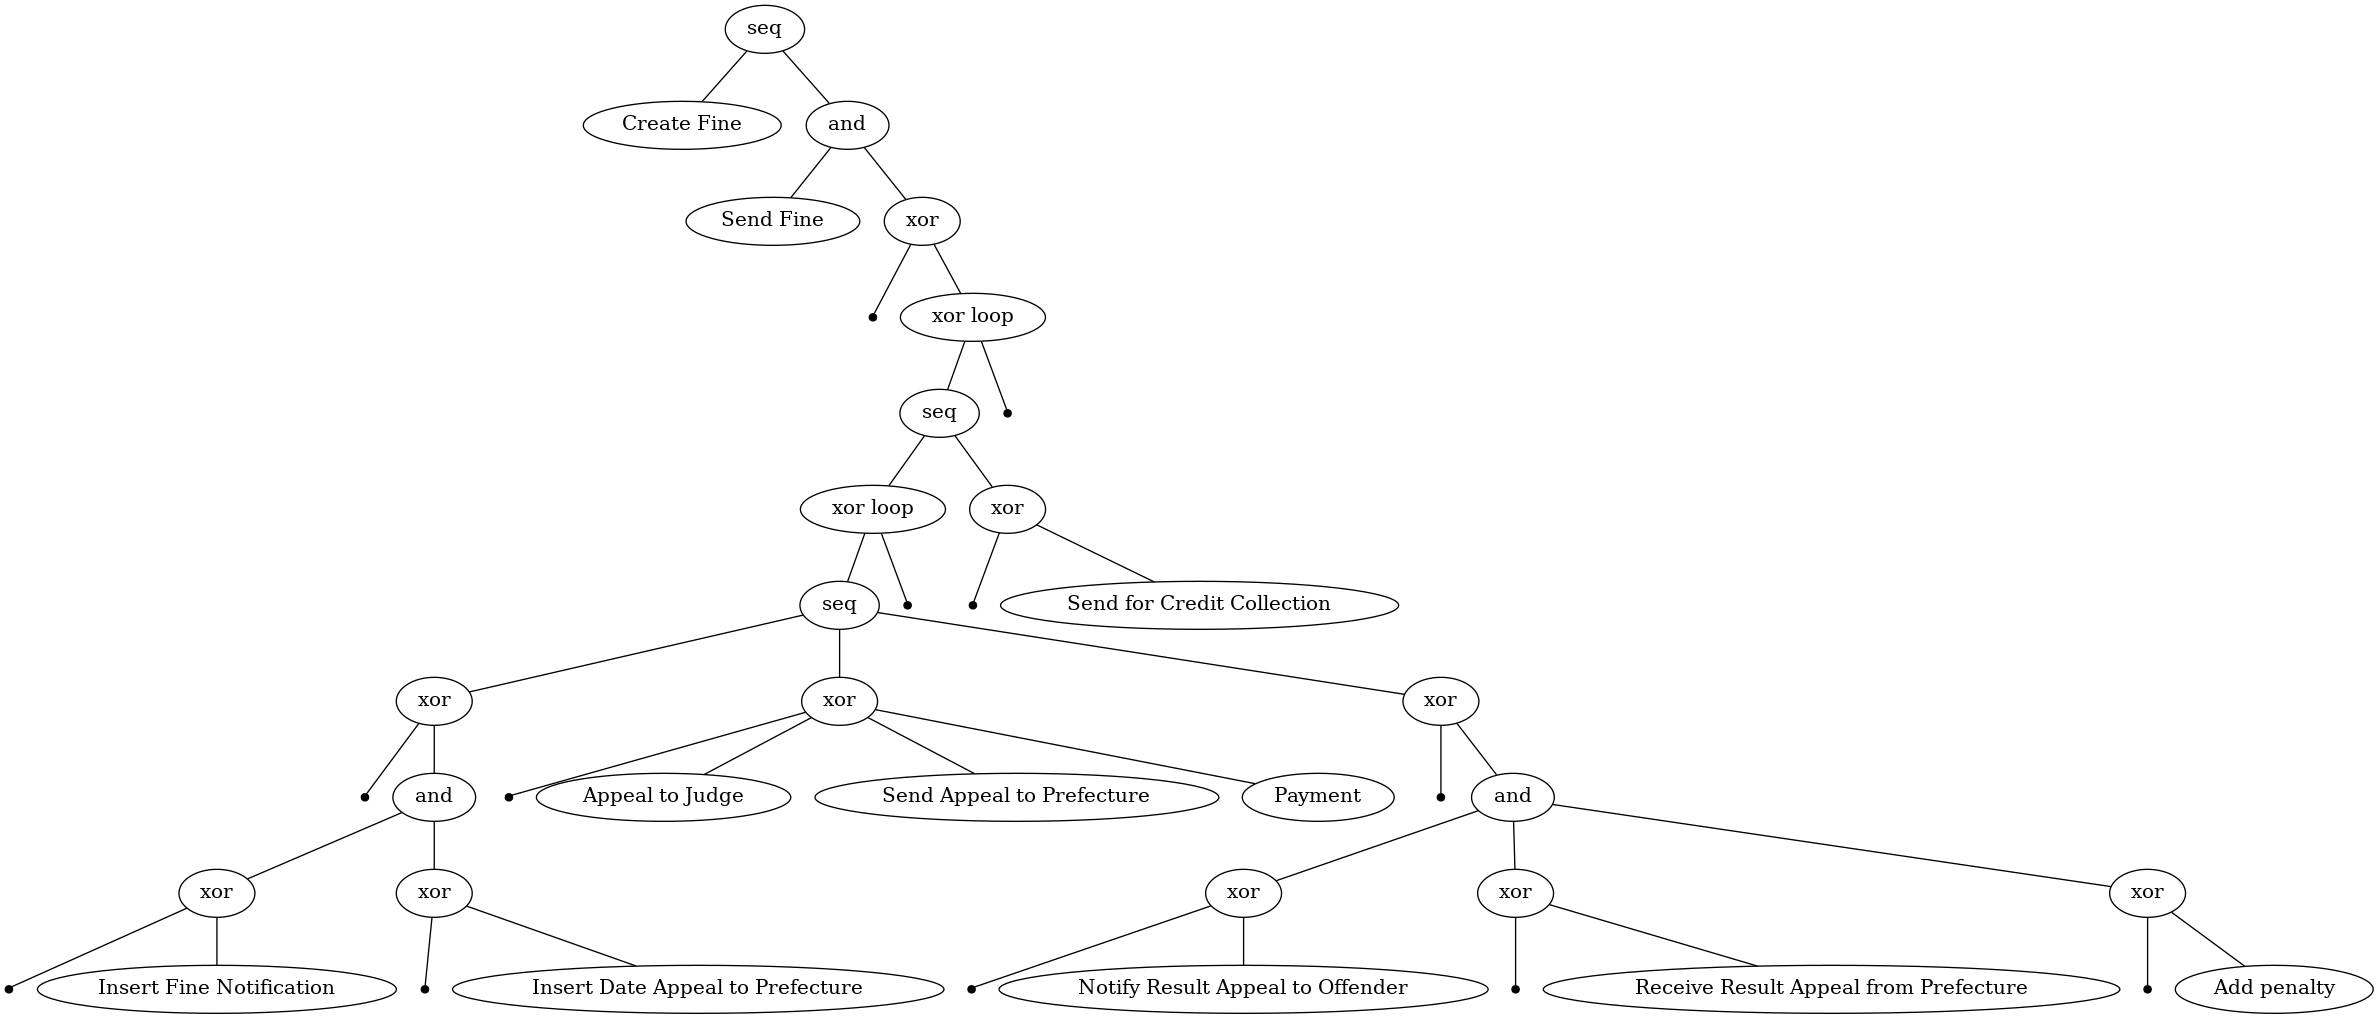

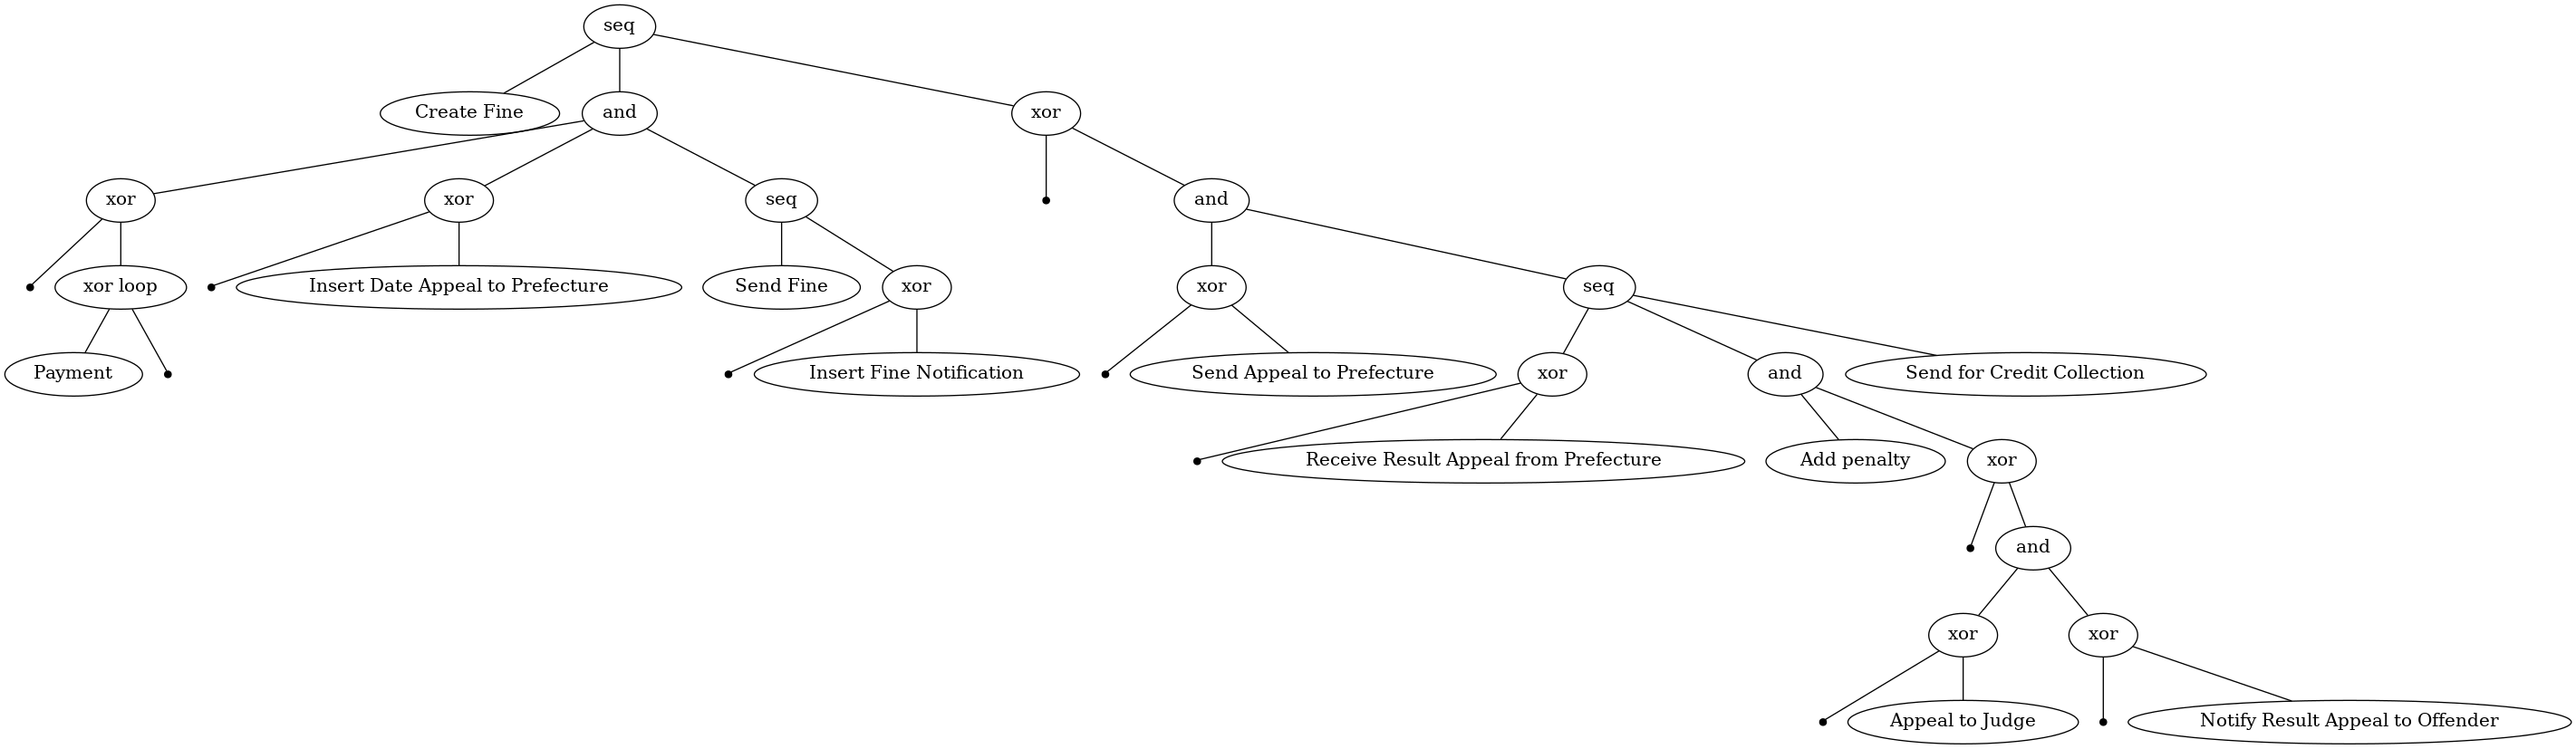

In [65]:
'Visualize Process Tree'
tree = inductive_miner.apply_tree(log)
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

tree = inductive_miner.apply_tree(log, variant=inductive_miner.Variants.IMf)
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)